# <a name="top"></a>SWPLA PDDA 2020 Synthetic Sonic Log Generation Contest

**Author:** Ben Dowdell

**Date:** March XX, 2020

**Purpose:** To minimize RMSE in predicting Sonic logs (compressional & shear) from a suite of standard well logs

**Outline**

* [1. Initial Set-Up](#initial-setup)
** [1a. Standard Imports](#standard-imports)
** [1b. Sklearn Imports](#sklearn-imports)
** [1c. Helper Function Definitions](#helper-funcs)
* [2. Read Data](#read-data)
* [3. Inspect Data](#inspect-data)
* [4. EDA](#eda)
* [5. Imputing Missing Values](#imputing)
** [5a. PE estimation](#fe-pe)
* [6. DTC & DTS Model Train/Test](#model)

### Data Decription
#### Files
#### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


#### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

## <a name="initial-setup"></a>1. Initial Set-Up

Back to [top](#top)

### <a name="standard-imports"></a> 1a. Standard Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from pprint import pprint

random_state = 42
rng = np.random.RandomState(seed=42)

%matplotlib inline

### <a name="sklearn-imports"></a>1b. Sklearn Imports

In [260]:
# Preprocessing utilities
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE, f_regression

# Model k-fold Cross Validation score for generalization evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering Models
from sklearn.cluster import KMeans

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Yellowbrick tools for model analysis
from yellowbrick.features import Rank1D, Rank2D
from yellowbrick.features import PCA as PCA_yb
from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.model_selection import FeatureImportances, RFECV
from yellowbrick.regressor import ResidualsPlot, PredictionError

### Statsmodels imports

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

### <a name="helper-funcs"></a>1c. Helper Function Definitions

Helper function to plot data histograms

In [209]:
def plot_data_distributions(df):
    """Plot histograms of each curve
    
    Paramters:
    df (pandas.DataFrame) : Input data frame containing log curves
    
    Returns:
    matplotlib.figure.Figure
    """
    n_subplots = len(df.columns.to_list())
    if n_subplots % 2 == 0:
        n_rows = 2
        n_cols = n_subplots / n_rows
    elif n_subplots % 3 == 0:
        n_rows = 3
        n_cols = n_subplots / n_rows
    else:
        n_cols = n_subplots // 2
        n_rows = n_subplots // n_cols
        n_rows += n_subplots % n_cols
        n_blank = (n_rows * n_cols) - n_subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12,8))
    axes[-1,-n_blank].axis('off')
    for ax, col in zip(axes.flatten(), df.columns.tolist()):
        ax.hist(df[col])
        if 'HR' in col:
            ax.set_xscale('log')
        ax.set_title('{} Histogram'.format(col))
    plt.tight_layout()
    return fig

Helper function plot data CDF's

In [24]:
def plot_data_cdf(df):
    """Plot cumulative distribution function of each curve
    
    Parameters:
    df (pandas.DataFrame) : Input data frame containing log curves
    
    Returns:
    matplotlib.figure.Figure
    """
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18,8))
    for ax, col in zip(axes.flatten(), df.columns.tolist()):
        ax.hist(df[col], density=True, cumulative=-1)
        if 'HR' in col:
            ax.set_xscale('log')
        ax.set_title('{} Histogram'.format(col))
    plt.tight_layout()
    return fig

Helper function to plot well curves in a normal log display

In [25]:
def plot_well_curves(data):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data (pandas.DataFrame) : Input data frame containing the well log curves, one per column
    
    curve_names (list) : A list containing the column name of each well log curve in the input data frame
    
    Returns:
    matplotlib.figure.Figure
    """
    # get the column names as a list
    curve_names = data.columns.tolist()
    
    # create the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data[curve], data.index, color='k')
        else:
            ax.plot(data[curve], data.index, color='k')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS'] or 'DT' in curve:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to remove outliers from log curves using standard deviation from median value in a window

In [26]:
def filter_curves(data, window, n_std):
    """
    Takes a data frame containing well log curves and filters outliers based on n-standard deviations
    from a median filtered version of the data.
    
    Parameters:
    data (pandas.DataFrame) : The input data frame containing data to be filtered.  Each column is a well log curve.
    
    window (int) : The size of the window to use in creating a median filtered curve (recommend 33)
    
    n_std (int) : The number of +/- standard deviations to use in considering outliers (recommend 2)
    
    Returns:
    df_clean (pandas.DataFrame) : The filtered well curves
    df_outliers (pandas.DataFrame) : The outlier data points removed by the filtering operation
    """
    # create a copy of the original data
    df_copy = data.copy()
    
    # create a data frame containing median-filtered version of the data
    df_medfilter = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_medfilter[col] = df_copy[col].rolling(window, min_periods=1, center=True).median()
        
    # create a data frame containing standard deviation of the data
    df_stddev = pd.DataFrame()
    for col in df_copy.columns.tolist():
        df_stddev[col] = df_medfilter[col].rolling(window, min_periods=1, center=True).std()
        
    # create a data frame containing the cleaned version of the data using standard deviation from the median filtered data
    # and create a data frame containing the removed outliers
    df_clean = pd.DataFrame()
    df_outliers = pd.DataFrame()
    for col in df_copy.columns.tolist():
        upper = df_medfilter[col] + df_stddev[col]*n_std
        lower = df_medfilter[col] - df_stddev[col]*n_std
        df_clean[col] = df_copy[col].where((df_copy[col] <= upper) & (df_copy[col] >= lower))
        #df_clean[col] = df_clean[col].interpolate(limit_area='inside')
        df_outliers[col] = df_copy[col].where(df_clean[col] != df_copy[col])
    
    return df_clean, df_outliers

Helper function to compare raw versus filtered logs

In [27]:
def qc_curve_filt(data_raw, data_cleaned, *args):
    """
    Plots well log curves from an input data frame containing the data
    
    Parameters:
    data_raw (pandas.DataFrame) : Input data frame containing the well log curves, one log per column
    
    data_cleaned (pandas.DataFrame) : Input data frame containing filtered log curves, one log per column
    
    *args (pandas.DataFrame) : Optional data frame containing outliers
    
    Returns:
    matplotlib.figure.Figure
    """
    
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = data_raw.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Training Well Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.semilogx(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.semilogx(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        else:
            ax.plot(data_raw[curve], data_raw.index, color='k', lw=3)
            ax.plot(data_cleaned[curve], data_cleaned.index, color='r', lw=1)
            for arg in args:
                ax.plot(arg[curve], arg.index, lw=0, marker='.', mfc='y', mec='k', alpha=0.2)
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to compare individual predictors to DTC & DTS

In [28]:
def compare_curves(predictor, dtc, dts):
    """
    Takes a predictor curve and plots it against both response variables, DTC & DTS
    
    Parameters:
    predictor (pandas.core.series.Series) : Independent Variable to compare, assumes either a column from a pandas DataFrame or ndarray-like
    
    dtc (pandas.core.series.Series) : DTC curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    dts (pandas.core.series.Series) : DTS curve, assumes either a column from a pandas DataFrame or ndarray-like
    
    Returns:
    matplotlib.figure.Figure
    """
    fig = plt.figure(figsize=(20,10), linewidth=5, edgecolor='k')
    name = predictor.name
    fig.suptitle('{} curve comparison to DTC & DTS'.format(name), fontsize=20)
    
    ax1 = fig.add_subplot(2,2,1)
    if name == 'HRD':
        ax1.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax1.plot(predictor.index, predictor.values, 'k', lw=3)
    ax1c = ax1.twinx()
    ax1c.plot(dtc.index, dtc.values, 'r', lw=2)
    ax1c.invert_yaxis()
    ax1.set_ylabel(name)
    ax1c.set_ylabel('DTC', fontdict={'color':'r'})
    ax1.grid(False)
    ax1c.grid(False)
    
    ax2 = fig.add_subplot(2,2,2)
    ax2 = sns.scatterplot(x=predictor, y=dtc)
    if name == 'HRD':
        ax2.set_xscale('log')
    ax2.set_xlabel(name)
    ax2.set_ylabel('DTC')
    ax2.grid(False)
    
    ax3 = fig.add_subplot(2,2,3)
    if name == 'HRD':
        ax3.semilogy(predictor.index, predictor.values, 'k', lw=3)
    else:
        ax3.plot(predictor.index, predictor.values, 'k', lw=3)
    ax3c = ax3.twinx()
    ax3c.plot(dts.index, dts.values, 'r', lw=2)
    ax3c.invert_yaxis()
    ax3.set_ylabel(name)
    ax3c.set_ylabel('DTS', fontdict={'color':'r'})
    ax3.grid(False)
    ax3c.grid(False)
    
    ax4 = fig.add_subplot(2,2,4)
    ax4 = sns.scatterplot(x=predictor, y=dts)
    if name == 'HRD':
        ax4.set_xscale('log')
    ax4.set_xlabel(name)
    ax4.set_ylabel('DTS')
    ax4.grid(False)
    
    return fig

Helper function to calculate Root Mean Squared Error (RMSE), the primary evaluation metric for this project.

In [29]:
def evaluate_rmse(real, predicted):
    """Calculates the Root Mean Square Error
     
     Parameters:
     real (ndarray) : actual values as a numpy array
     predicted (ndarray) : predicted values as a numpy array
     
     Returns: RMSE Accuracy as a float
     
    """
    mse = np.square(np.subtract(real, predicted)).mean()
    return np.sqrt(mse)

Helper function to plot logs in a typical petrophysical layout

In [30]:
def petro_plot(gr, resd, neut, den, pe, dtc, dts):
    """
    Produces a typical petrophysical plot
    
    Parameters:
    gr (pandas.Series) : Gamma Ray curve as a pandas series
    resd (pandas.Series) : Deep Resistivity curve as a pandas series
    neut (pandas.Series) : Neutron Porosity curve as a pandas series
    den (pandas.Series) : Density curve as a pandas series
    pe (pandas.Series) : PE curve as a pandas series
    dtc (pandas.Series) : Compressional sonic curve as a pandas series
    dts (pandas.Series) : Shear sonic curve as a pandas series
    
    Returns : matplotlib.figure.Figure
    """
    
    fig = plt.figure(figsize=(20,12))

    # GR
    ax1 = fig.add_subplot(1,5,1)
    ax1.plot(gr, gr.index, 'k', lw=1)
    ax1.invert_yaxis()
    ax1.set_xlabel('GR')
    ax1.set_ylabel('Sample no.')
    ax1.xaxis.tick_top()
    ax1.set_xlim([0, 300])
    ax1.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300])
    ax1.xaxis.set_label_position('top')

    # RD
    ax2 = fig.add_subplot(1,5,2)
    ax2.semilogx(resd, resd.index, 'b', lw=1)
    ax2.set_xlabel('HRD')
    ax2.invert_yaxis()
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top')

    # N-D
    ax3 = fig.add_subplot(1,5,3)
    ax3.plot(den, den.index, 'r', lw=1)
    ax3.xaxis.set_label_position('top')
    ax3.set_xlabel('ZDEN', labelpad=10, fontdict={'color':'r'})
    ax3.set_xlim(1.65, 2.65)
    ax3.invert_yaxis()
    ax3b = ax3.twiny()
    ax3b.plot(neut, neut.index, 'g', lw=1)
    ax3b.invert_xaxis()
    ax3b.set_xlabel('CNC', fontdict={'color':'g'})
    ax3b.set_xlim(0.6, 0.0)
    ax3b.xaxis.tick_top()
    ax3.xaxis.tick_top()
    ax3.set_xticks([1.65, 1.85, 2.05, 2.25, 2.45, 2.65])
    ax3.tick_params(axis='x', pad=35, top=True)
    ax3b.xaxis.set_label_position('top')
    ax3b.set_xticks([0.6, 0.48, 0.36, 0.24, 0.12, 0.0])

    # PE
    ax4 = fig.add_subplot(1,5,4)
    ax4.plot(pe, pe.index, 'k', lw=1)
    ax4.set_xlabel('PE')
    ax4.invert_yaxis()
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')

    # Sonic
    ax5 = fig.add_subplot(1,5,5)
    ax5.plot(dtc, dtc.index, 'b', lw=1)
    ax5.xaxis.set_label_position('top')
    ax5.set_xlabel('DTC', labelpad=10, fontdict={'color':'b'})
    ax5.set_xlim(50, 170)
    ax5.invert_xaxis()
    ax5.invert_yaxis()
    ax5b = ax5.twiny()
    ax5b.plot(dts, dts.index, 'r', lw=1)
    ax5b.invert_xaxis()
    ax5b.set_xlabel('DTS', fontdict={'color':'r'})
    ax5b.set_xlim(340, 100)
    ax5b.xaxis.tick_top()
    ax5.xaxis.tick_top()
    #ax5.set_xticks([170, 150, 130, 110, 90, 70, 50])
    ax5.set_xticks([230, 200, 170, 140, 110, 80, 50])
    ax5.tick_params(axis='x', pad=35, top=True)
    ax5b.xaxis.set_label_position('top')
    #ax5b.set_xticks([340, 300, 260, 220, 180, 140, 100])
    ax5b.set_xticks([460, 400, 340, 280, 220, 160, 100])

    plt.tight_layout()
    return fig

Helper function to plot RHOMAA-UMAA

In [31]:
def plot_rhomaa_umaa(pe, dens, phi):
    """Plot log data using RHOMAA-UMAA crossplot for mineralogy
    
    Parameters:
    pe (ndarray-like) : PE curve
    dens (ndarray-like) : Density curve
    phi (ndarray-like) : Neutron porosity curve
    color_var (optional) : Default 'None' will use index as color.  Option to pass in labels such as kmeans.labels_
    
    Returns:
    matplotlib.figure.Figure
    """
    # First, create the endmember points as a dataframe
    index = ['Quartz', 'Calcite', 'Dolomite', 'Anhydrite', 'K-Feldspar']
    data = {
        'rhoma' : [2.65, 2.71, 2.87, 2.95, 2.54],
        'uma' : [4.82, 13.79, 8.98, 14.99, 7.29],
    }
    df = pd.DataFrame(data=data, index=index)
    
    # Second, calculate umaa & rhomaa for the input logs
    u = pe * dens
    phid = (2.65 - dens)/(2.65-1.)
    phit = (phid + phi)/2
    #umaa = u / (1 - phit)
    #umaa = (u - phit*0.5)/(1-phit)/2
    rhomaa = (dens - phit*1.)/(1-phit) # assume brackish pore fluid rhof = 1.1 g/cc
    umaa = (pe * rhomaa) / 2
    
    # Finally, create and return figure
    fig = plt.figure(figsize=(28,10))
    
    gs = fig.add_gridspec(1, 6)
    
    ax1 = fig.add_subplot(gs[0,:-3])
    im = ax1.scatter(umaa, rhomaa, s=10, c=umaa.index, marker='.', cmap='inferno', alpha=0.8)
    ax1.scatter(df['uma'], df['rhoma'], c='r', marker='D')
    for i, txt in enumerate(df.index.tolist()):
        ax1.annotate(txt, (df['uma'].iloc[i]+0.03, df['rhoma'].iloc[i]-0.02), weight='bold')
    ax1.plot(df['uma'].loc[['Quartz','Calcite']], df['rhoma'].loc[['Quartz', 'Calcite']], 'k')
    ax1.plot(df['uma'].loc[['Quartz', 'Dolomite']], df['rhoma'].loc[['Quartz', 'Dolomite']], 'k')
    ax1.plot(df['uma'].loc[['Dolomite','Calcite']], df['rhoma'].loc[['Dolomite','Calcite']], 'k')
    ax1.set_xlabel('UMAA (barns/cc)')
    #ax1.set_xlim(2,16)
    ax1.set_ylabel('RHOMAA (g/cc)')
    #ax1.set_ylim(2.3, 3.1)
    ax1.invert_yaxis()
    ax1.set_title('RHOMAA-UMAA Crossplot', fontdict={'fontsize':20, 'fontweight':'bold'})
    cbar = fig.colorbar(im, ax=ax1)
    cbar.ax.invert_yaxis()
    cbar.set_label('sample no', fontdict={'fontweight':'bold'})
    
    ax4 = fig.add_subplot(gs[0,3])
    ax4.plot(phit, phit.index, 'k', lw=2, label='phit')
    ax4.plot(phi, phi.index, 'r', lw=0.5, label='phin')
    ax4.plot(phid, phid.index, 'g', lw=0.5, label='phid')
    ax4.invert_yaxis()
    ax4.set_ylabel('sample no')
    ax4.invert_xaxis()
    ax4.set_xlabel('Phi')
    ax4.xaxis.tick_top()
    ax4.xaxis.set_label_position('top')
    ax4.legend(loc='best')
    
    ax5 = fig.add_subplot(gs[0,4], yticklabels=())
    ax5.plot(umaa, umaa.index)
    ax5.invert_yaxis()
    ax5.set_xlabel('UMAA')
    ax5.xaxis.tick_top()
    ax5.xaxis.set_label_position('top')
    
    ax6 = fig.add_subplot(gs[0,5], yticklabels=())
    ax6.plot(rhomaa, rhomaa.index)
    ax6.invert_yaxis()
    ax6.set_xlabel('RHOMAA')
    ax6.xaxis.tick_top()
    ax6.xaxis.set_label_position('top')
    
    return fig, rhomaa, umaa
        
    

Helper function to plot Vp versus Vs using well known rock physics templates

In [192]:
def plot_vp_vs(x='DTC', y='DTS', color='index', df=None):
    """
    Plots measured Vp & Vs against well-known rock physics trends
    
    Parameters:
    x (pandas.Series) : Input DTC values, in us/ft
    y (pandas.Series) : Input DTS values, in us/ft
    color (str) : Input variable for coloring scatter plot, acceptable values are 'index' and df column names
    df (pandas.DataFrame) : Input data frame containing x & y
    
    Returns:
    matplotlib.figure.Figure
    """
    
    vp_ft_s = 1e6 / df[x]
    vp_m_s = vp_ft_s /  3.281
    vp_km_s = vp_m_s / 1000
    
    vs_ft_s = 1e6 / df[y]
    vs_m_s = vs_ft_s / 3.281
    vs_km_s = vs_m_s / 1000
    
    xvp = np.arange(start=0, stop=8, step=0.1)
    
    df_keys = df.columns.to_list()
    color_mapping = dict()
    color_mapping['index'] = df.index
    
    for key in df_keys:
        if key not in color_mapping:
            color_mapping[key] = df[key]
    
    Vs_castagna_ls = np.multiply(-0.05508, np.power(xvp, 2)) + np.multiply(1.0168, xvp) - 1.0305
    Vs_castagna_dm = np.multiply(0.5832, xvp) - 0.07776
    Vs_castagna_mudrock = np.multiply(0.8621, xvp) - 1.1724
    Vs_castagna_ss = np.multiply(0.8042, xvp) - 0.8559
    
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(Vs_castagna_ls, xvp, '--b', lw=2, label='Castagna et al. (1993) Water-saturated Limestone')
    ax.plot(Vs_castagna_dm, xvp, '--c', lw=2, label='Castagna et al. (1993) Water-saturated Dolomite')
    ax.plot(Vs_castagna_mudrock, xvp, '--k', lw=2, label='Castagna et al. (1993) Mudrock line')
    ax.plot(Vs_castagna_ss, xvp, '--r', lw=2, label='Castagna et al. (1993) Water-saturated sandstone')
    im = ax.scatter(vs_km_s, vp_km_s, s=10, c=color_mapping[color], marker='.', cmap='inferno', alpha=0.8)
    ax.set_xlabel('Vs (km/s)')
    ax.set_ylabel('Vp (km/s)')
    ax.set_title('Vp vs. Vs', fontsize=20, fontweight='bold')
    ax.set_xlim([np.nanmin(vs_km_s), np.nanmax(vs_km_s)])
    ax.set_ylim([np.nanmin(vp_km_s), np.nanmax(vp_km_s)])
    ax.legend(loc='upper left')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.invert_yaxis()
    cbar.set_label(f'{color}', fontdict={'fontweight':'bold'})
    
    return fig

Helper function to plot Training Real vs. Training Predicted

In [33]:
def plot_real_vs_pred(y, y_pred, feat_name, split):
    """Function that plots y vs y_pred
    
    Parameters:
    y (ndarray like) : real values
    y_pred (ndarray like) : predicted values
    feat_name (str) : Feature name
    split (str) : Whether this is 'Train', 'Test', or 'Full Log'
    
    returns matplotlib.figure.Figure
    """
    
    o2o = np.linspace(0, np.nanmax(y), len(y))
    
    fig = plt.figure(figsize=(20,6))
    fig.suptitle('Real {} vs. Predict'.format(split))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(y.reset_index(drop=True, inplace=False), 'k', lw=2, label='y {}'.format(split))
    ax1.plot(y_pred, 'r', lw=1, label='y_{}_pred'.format(split))
    ax1.set_xlabel('sample no.')
    ax1.set_ylabel(feat_name)
    ax1.set_title('{} Real & Predict'.format(split))
    ax1.legend(loc='best')
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.scatter(y, y_pred, s=10, marker='.', alpha=0.8)
    ax2.plot(o2o, o2o, 'k', lw=2, label='one-to-one')
    ax2.set_xlabel('{} Real {}'.format(feat_name, split))
    ax2.set_ylabel('{} Predict {}'.format(feat_name, split))
    ax2.legend(loc='best')
    ax2.set_title('{} {} Predict vs. Real'.format(feat_name, split))
    
    return fig

Helper function to visually QC original vs. imputed data

In [34]:
def plot_original_vs_imputed(df_original, df_imputed):
    """Plots original and imputed log curves for visual QC
    
    Parameters:
    df_original (pandas.DataFrame) : Input data frame containing the well log curves, one log per column
    
    df_imputed (pandas.DataFrame) : Input data frame containing filtered log curves, one log per column
    
    Returns:
    matplotlib.figure.Figure
    """
    
    # get the column names as a list, assumes col names are the same for each input data frame
    curve_names = df_original.columns.tolist()
    
    # build the figure
    fig, axes = plt.subplots(nrows=1, ncols=len(curve_names), sharey=True, figsize=(20,10))
    fig.suptitle('Original vs Imputed Data', fontsize=20)
    for ax, curve in zip(axes, curve_names):
        if curve in ['HRD', 'HRM']:
            ax.semilogx(df_imputed[curve], df_imputed.index, color='r', lw=0.5, label='imputed')
            ax.semilogx(df_original[curve], df_original.index, color='k', lw=2, label='original')
        else:
            ax.plot(df_imputed[curve], df_imputed.index, color='r', lw=0.5, label='imputed')
            ax.plot(df_original[curve], df_original.index, color='k', lw=2, label='original')
        if curve == 'CNC':
            ax.set_xlim(0.0, 1.0)
        if curve in ['DTC', 'DTS']:
            ax.set_title(curve, fontdict={'color':'r'})
            ax.invert_xaxis()
        else:
            ax.set_title(curve)
        ax.xaxis.tick_top()
        ax.invert_yaxis()
        ax.legend(loc='upper left')
    fig.text(0.04, 0.5, 'Sample', va='center', rotation='vertical', fontdict={'fontsize':20})
    return fig

Helper function to find consecutive NaN values and the starting index number
[Consecutive NaN larger than threshold](https://stackoverflow.com/questions46007776/consecutive-nan-larger-than-threshold-in-pandas-dataframe)

In [35]:
def consecutive_nans(index, col, threshold):
    """Function returns the starting index of consecutive NaN's in an input column
    Uses Divakar's answer in above link
    """
    
    thresh = threshold
    
    a = index.values
    b = col.values
    
    idx0 = np.flatnonzero(np.r_[True, np.diff(np.isnan(b))!=0, True])
    count = np.diff(idx0)
    idx = idx0[:-1]
    valid_mask = (count>=thresh) & np.isnan(b[idx])
    out_idx = idx[valid_mask]
    out_num = a[out_idx]
    out_count = count[valid_mask]
    out = range(int(out_num),int(out_num)+int(out_count)-1)
    
    return out

Helper function to plot custom [heatmap](https://github.com/amueller/mglearn/blob/master/mglearn/tools.py)

In [36]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

## 2. <a name="read-data"></a>Read in Data

Back to [top](#top)

In [37]:
df_w1 = pd.read_csv('../data/train.csv')

In [38]:
df_w1.head()

CAL    CNC       GR    HRD    HRM     PE   ZDEN       DTC       DTS
0 -999.0 -999.0  41.4699 -999.0 -999.0 -999.0 -999.0  128.0737  319.0654
1 -999.0 -999.0  42.5053 -999.0 -999.0 -999.0 -999.0  127.8347  318.7825
2 -999.0 -999.0  43.1548 -999.0 -999.0 -999.0 -999.0  127.2307  317.3323
3 -999.0 -999.0  43.2410 -999.0 -999.0 -999.0 -999.0  126.2917  313.6486
4 -999.0 -999.0  40.3218 -999.0 -999.0 -999.0 -999.0  125.3985  307.8903

## 3. <a name="inspect-data"></a>Inspect Data

Back to [top](#top)

In [39]:
df_w1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
CAL     30143 non-null float64
CNC     30143 non-null float64
GR      30143 non-null float64
HRD     30143 non-null float64
HRM     30143 non-null float64
PE      30143 non-null float64
ZDEN    30143 non-null float64
DTC     30143 non-null float64
DTS     30143 non-null float64
dtypes: float64(9)
memory usage: 2.1 MB


All data are type float64

In [40]:
df_w1.describe().transpose()

count       mean         std    min        25%       50%        75%  \
CAL   30143.0  -8.394576  129.970219 -999.0    8.05835    8.6250    9.04885   
CNC   30143.0 -23.692615  157.142679 -999.0    0.12280    0.1936    0.33715   
GR    30143.0  38.959845  108.504554 -999.0   17.24875   36.8218   58.34615   
HRD   30143.0   3.977690  365.112753 -999.0    0.71770    1.6230    3.15830   
HRM   30143.0   1.547299  456.908969 -999.0    0.71205    1.6281    3.28060   
PE    30143.0 -17.446739  149.083136 -999.0    0.05310    4.9415    7.85665   
ZDEN  30143.0 -20.229982  148.809506 -999.0    2.22670    2.4322    2.55135   
DTC   30143.0 -54.891703  372.858812 -999.0   66.30435   78.3551  107.02250   
DTS   30143.0  -9.737567  440.314119 -999.0  118.53435  137.6893  182.97315   

             max  
CAL      21.0642  
CNC    3490.1582  
GR     1470.2534  
HRD   10000.0000  
HRM   60467.7617  
PE       28.1064  
ZDEN      3.2597  
DTC     155.9803  
DTS     487.4384

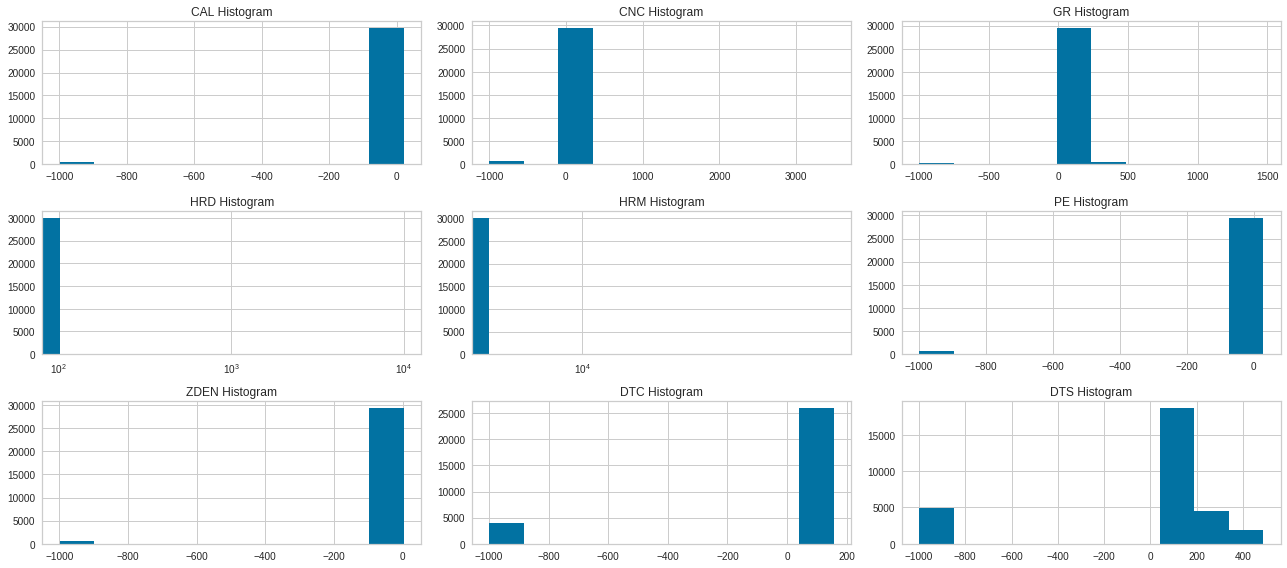

In [41]:
plot_data_distributions(df_w1.dropna())
plt.show()

Samples with value of -999.0 need to be replaced with NaN

In [42]:
df_w1.replace(to_replace=-999.0, value=np.nan, inplace=True)

In [43]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29408.0    0.683437   30.689679  -0.1028    0.127100    0.19850   
GR    29889.0   47.780541   51.377519  -0.1460   18.026100   37.08220   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29464.0    5.173227    4.781088  -0.0232    0.054200    5.04250   
ZDEN  29462.0    2.393818    0.196276  -1.9238    2.234800    2.43960   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.343100   3490.1582  
GR     58.532800   1470.2534  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.949700     28.1064  
ZDEN    2.553000      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

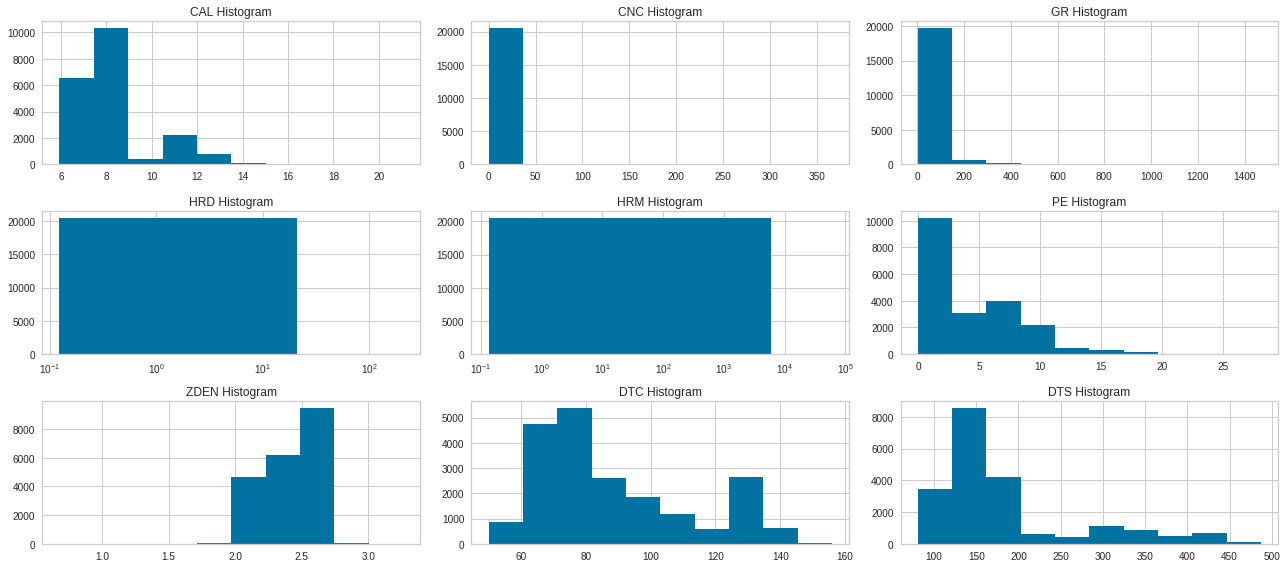

In [44]:
plot_data_distributions(df_w1.dropna())
plt.show()

There are some suspicious values here that we will explore in the next step.

1. CNC should range from 0.0 to 1.0
1. GR should not have values less than 0.0
1. PE should not have values less than 0.0
1. ZDEN should not have values less than 0.0

## <a name="eda"></a>4. Exploratory Data Analysis (EDA) & Cleaning

Back to [top](#top)

Before making any edits to values, plot the data for visual QC inspection

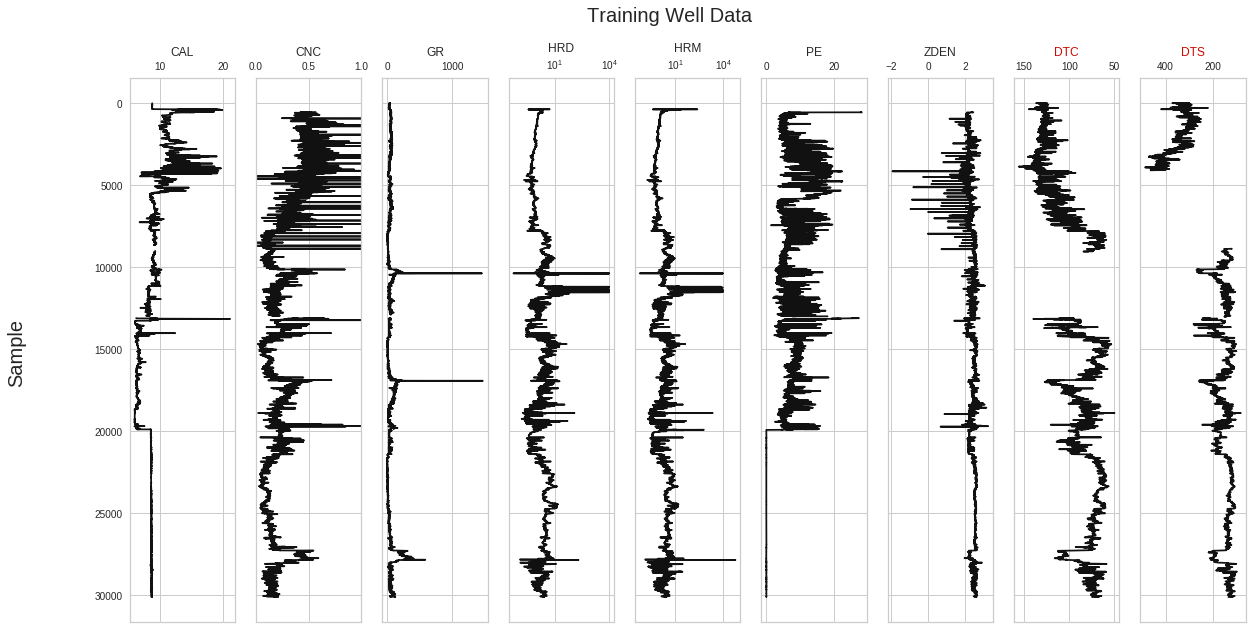

In [45]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Let's try a [RHOMAA-UMAA crossplot](http://www.kgs.ku.edu/Publications/Bulletins/LA/11_crossplot.html) to see if we can differentiate lithologies.

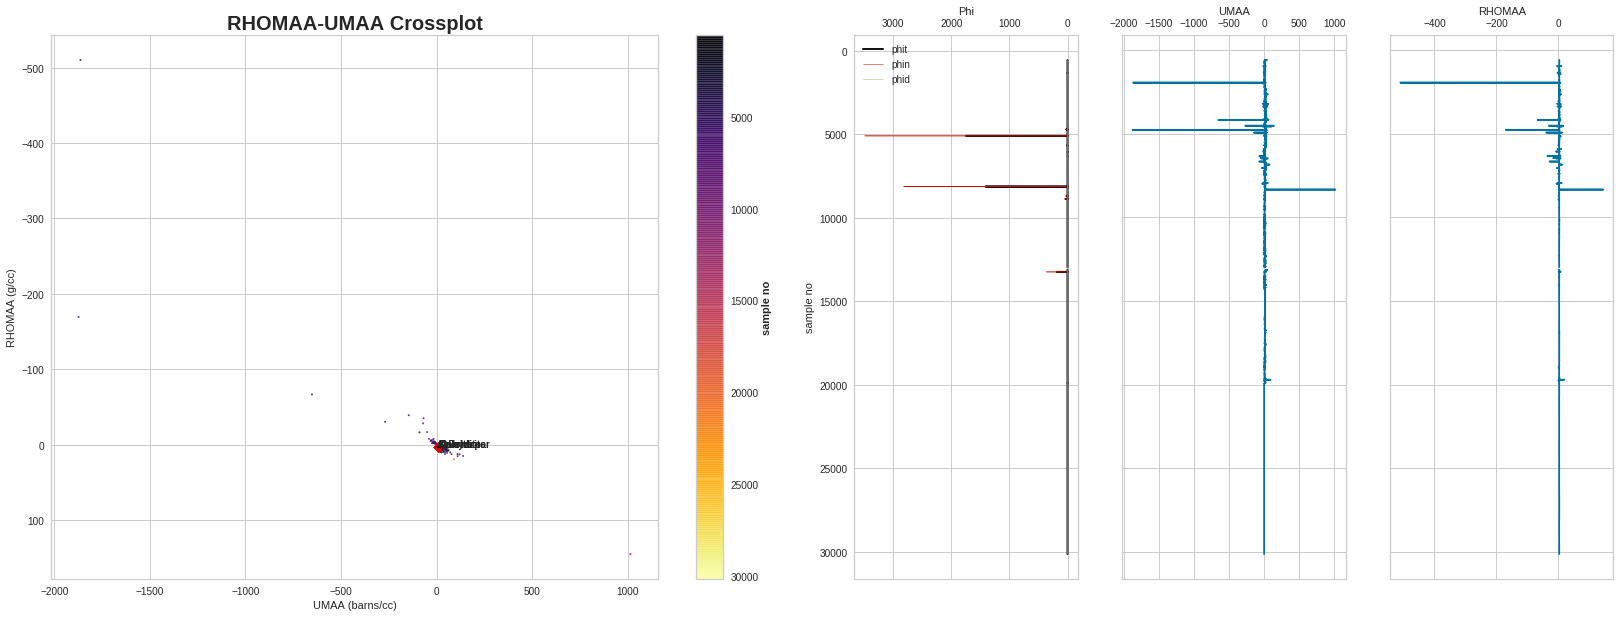

In [46]:
plot_rhomaa_umaa(df_w1['PE'], df_w1['ZDEN'], df_w1['CNC'])
plt.show()

Definitely outliers are present!

In [47]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29408.0    0.683437   30.689679  -0.1028    0.127100    0.19850   
GR    29889.0   47.780541   51.377519  -0.1460   18.026100   37.08220   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29464.0    5.173227    4.781088  -0.0232    0.054200    5.04250   
ZDEN  29462.0    2.393818    0.196276  -1.9238    2.234800    2.43960   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.343100   3490.1582  
GR     58.532800   1470.2534  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.949700     28.1064  
ZDEN    2.553000      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

Limit CNC to range between 0.0 and 1.0

In [48]:
df_w1.loc[df_w1['CNC'] < 0.0, ['CNC']] = np.nan
df_w1.loc[df_w1['CNC'] > 1.0, ['CNC']] = np.nan

Limit GR to range between 0.0 and 300.0

In [49]:
df_w1.loc[df_w1['GR'] < 0.0, ['GR']] = np.nan
df_w1.loc[df_w1['GR'] > 300.0, ['GR']] = np.nan

Limit PE to have values no less than 0.0

In [50]:
df_w1.loc[df_w1['PE'] < 0.0, ['PE']] = np.nan

Limit ZDEN to have values no less than 0.0

In [51]:
df_w1.loc[df_w1['ZDEN'] < 0.0, ['ZDEN']] = np.nan

In [52]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29308.0    0.247144    0.155301   0.0041    0.126800    0.19800   
GR    29685.0   45.468596   40.347602   0.0000   17.867400   36.87760   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29455.0    5.174812    4.780959   0.0000    0.054200    5.04380   
ZDEN  29454.0    2.394661    0.189292   0.0035    2.234900    2.43970   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.340900      0.9997  
GR     58.015600    299.9370  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.950150     28.1064  
ZDEN    2.553100      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

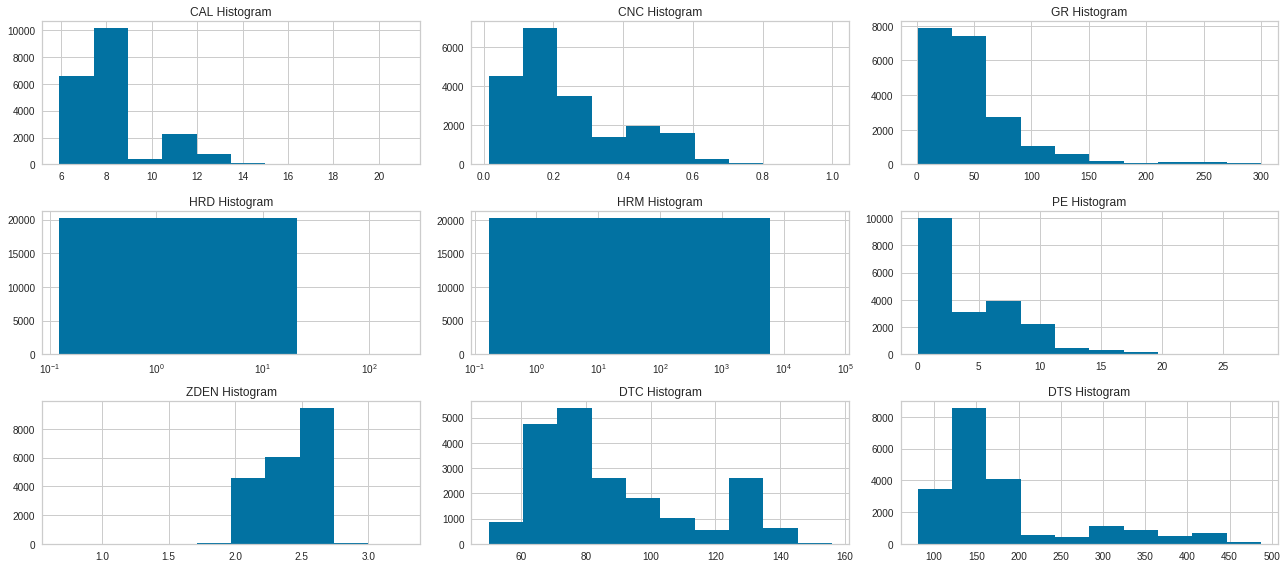

In [53]:
plot_data_distributions(df_w1.dropna())
plt.show()

These value ranges are substantially more acceptable.  Re-plot the data and visually inspect

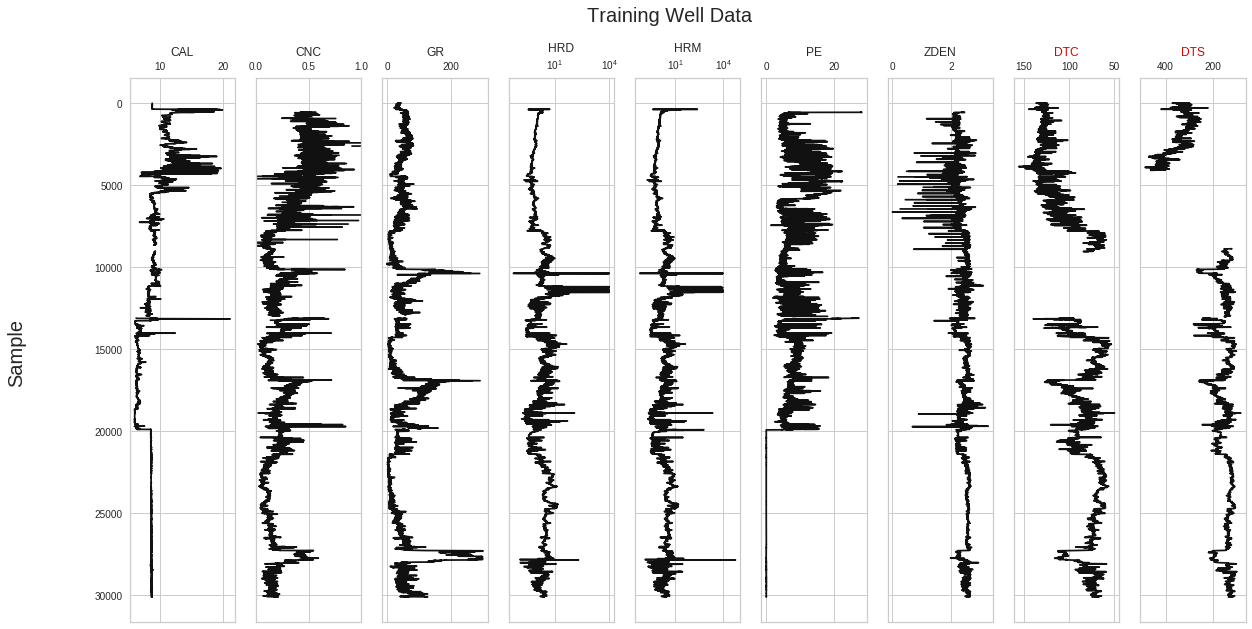

In [54]:
well_plot_fig = plot_well_curves(df_w1)
plt.show()

Overall, this appears to be better.  The PE final 10,000 values look suspect, though.

**Let's attempt filtering out the spikes remaining in the data.**

The filter first calculates an n-moving window median filtered version of the data and then eliminates values that fall outside of +/- n-standard deviations.

It might make sense to first standardize the data using RobustScaler (uses interquartile range 25-75% of the data) and pass the standardized data to the filter.

After filter, the data can be transformed back to its non-standardized domain.

In [55]:
rs = RobustScaler()
scaled_features = rs.fit_transform(df_w1.values)
scaled_features_df = pd.DataFrame(data=scaled_features, index=df_w1.index, columns=df_w1.columns)

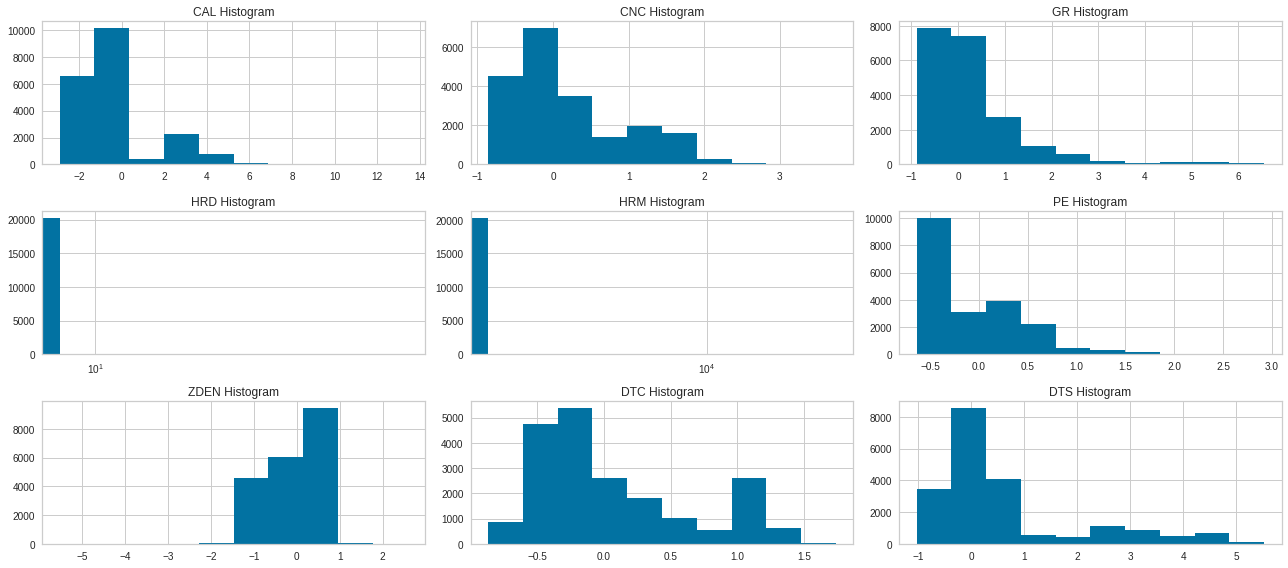

In [56]:
plot_data_distributions(scaled_features_df.dropna())
plt.show()

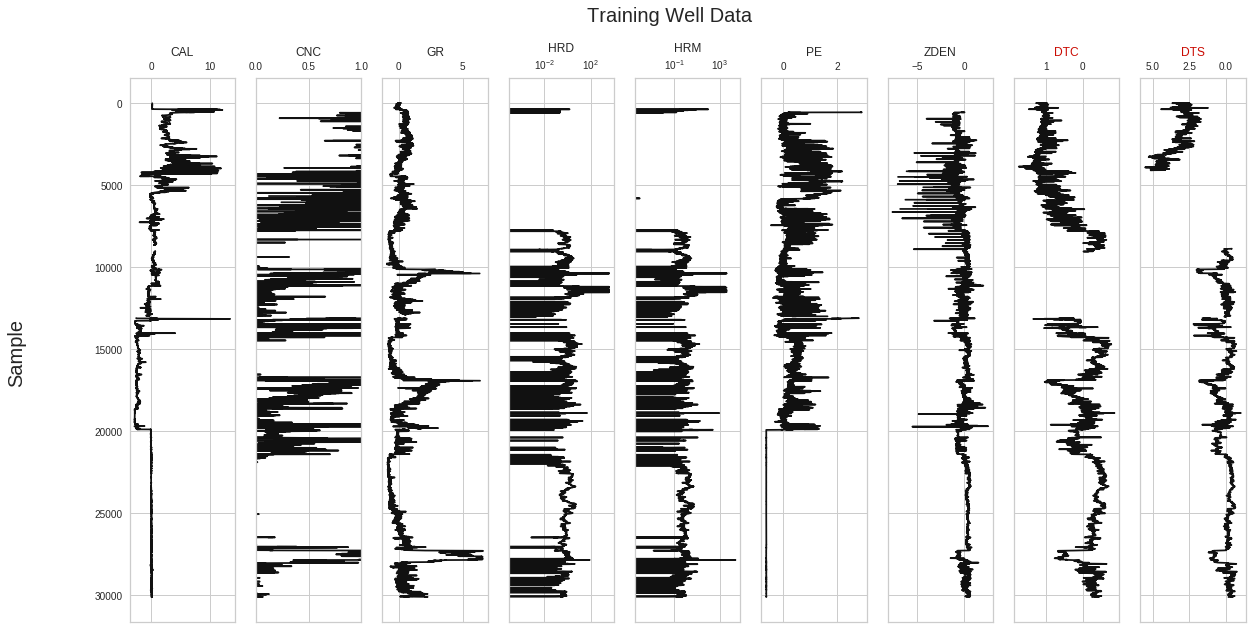

In [57]:
plot_well_curves(scaled_features_df)
plt.show()

Pass the scaled data to the filter and then backtransform the filtered data

In [58]:
df_clean_scaled, df_outliers_scaled = filter_curves(scaled_features_df, 81, 2)

# Backtransform the cleaned data & outliers to the unscaled domain
clean_unscaled = rs.inverse_transform(df_clean_scaled.values)
df_clean = pd.DataFrame(data=clean_unscaled, columns=df_w1.columns)
outliers_unscaled = rs.inverse_transform(df_outliers_scaled.values)
df_outliers = pd.DataFrame(data=outliers_unscaled, columns=df_w1.columns)

In [59]:
df_w1.describe().transpose()

count        mean         std      min         25%        50%  \
CAL   29633.0    8.654281    1.749145   5.9304    8.135600    8.62500   
CNC   29308.0    0.247144    0.155301   0.0041    0.126800    0.19800   
GR    29685.0   45.468596   40.347602   0.0000   17.867400   36.87760   
HRD   29758.0   16.953912  349.067878   0.0541    0.740450    1.66275   
HRM   29758.0   14.492077  445.361622   0.0616    0.734700    1.66515   
PE    29455.0    5.174812    4.780959   0.0000    0.054200    5.04380   
ZDEN  29454.0    2.394661    0.189292   0.0035    2.234900    2.43970   
DTC   26089.0   91.814381   24.337910  49.9705   71.357000   85.23760   
DTS   25278.0  180.655730   81.141960  80.5804  129.446625  144.59305   

             75%         max  
CAL     9.063000     21.0642  
CNC     0.340900      0.9997  
GR     58.015600    299.9370  
HRD     3.180350  10000.0000  
HRM     3.308900  60467.7617  
PE      7.950150     28.1064  
ZDEN    2.553100      3.2597  
DTC   112.112600    155.9803  
DTS   191.475125    487.4384

In [60]:
df_clean.describe().transpose()

count        mean        std      min         25%        50%  \
CAL   21632.0    8.652002   1.603670   5.9778    8.219875    8.62500   
CNC   15114.0    0.218983   0.132769   0.0315    0.121000    0.18250   
GR    15743.0   46.845773  42.946324   0.0000   19.049000   36.98350   
HRD   19642.0    2.887718   8.575268   0.1295    0.700500    1.62545   
HRM   18284.0    2.913507   9.047824   0.1853    0.690050    1.53440   
PE    11931.0    5.875870   4.673858   0.0265    0.065600    5.74090   
ZDEN  14373.0    2.406506   0.168309   1.9769    2.243200    2.45380   
DTC   14958.0   89.541953  23.340215  55.4076   70.700875   81.68805   
DTS   15411.0  179.289173  79.461633  96.9005  129.486900  145.15630   

             75%       max  
CAL     9.068925   19.5202  
CNC     0.278775    0.6868  
GR     57.620400  299.9302  
HRD     3.121525  231.2297  
HRM     3.170175  244.4038  
PE      8.175450   26.3707  
ZDEN    2.559200    2.8262  
DTC   106.334050  141.0543  
DTS   189.802350  455.3579

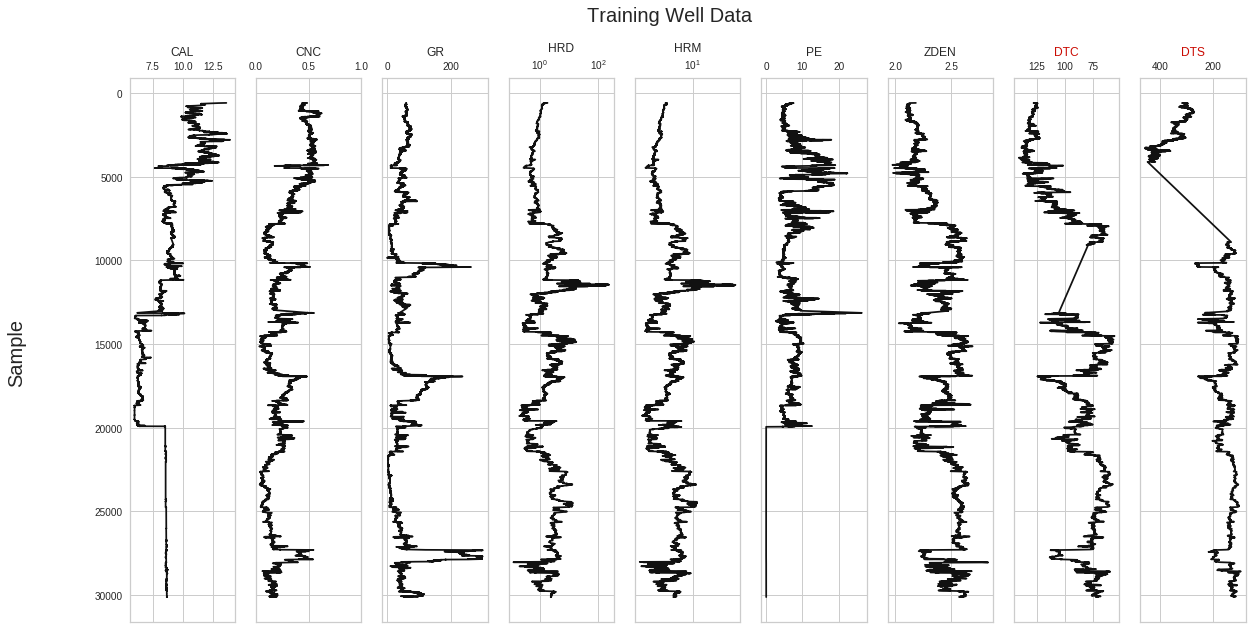

In [61]:
#cleaned_fig = plot_well_curves(df_clean)
cleaned_fig = plot_well_curves(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

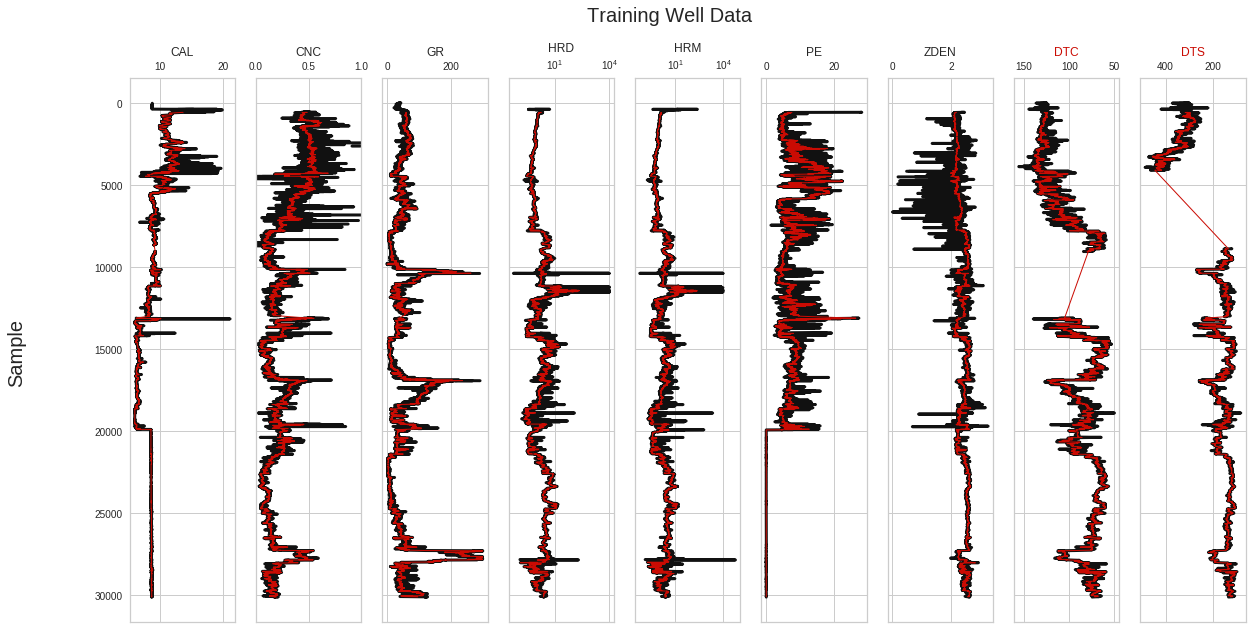

In [62]:
#qc_fig = qc_curve_filt(df_w1, df_clean)
qc_fig = qc_curve_filt(df_w1, df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
#qc_fig = qc_curve_filt(df_w1, df_clean, df_outliers)
plt.show()

**At this point, it seems prudent to make some plots comparing our final cleaned curves to established rock property trends as a QC of the imputation and filtering**

Use plot_vp_vs to plot the imputed data against well known lithology trends, first the *pre-imputation* data ...

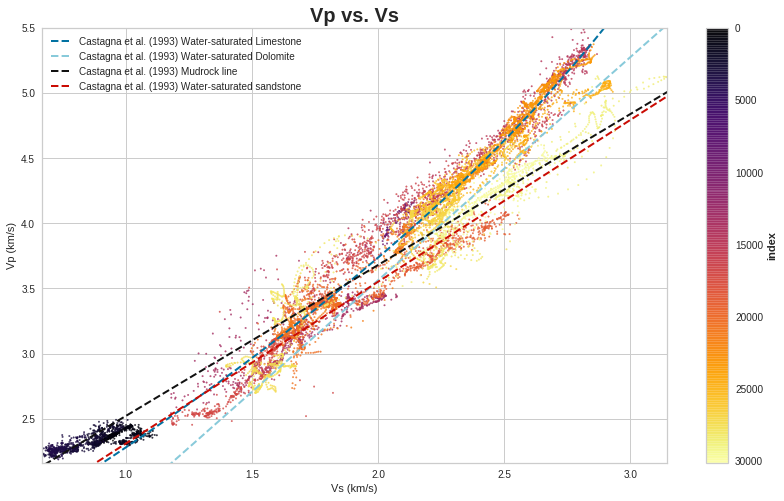

In [63]:
plot_vp_vs(x='DTC', y='DTS', df=df_clean)
plt.show()

**A few observations:**

1. Limestone appears to be a significant lithology.

1. Shale / Claystone also appear to be present throughout the well.

1. Sands are present.  Some sands may be difficult to discriminate in the overlap zone between Shale, Sand, & Limestone lines.  Gas-charged sands fall below the water-saturated sandstone line.

1. There may be a minor amount of dolomite present in the system.

1. Vp & Vs trends are obviously dependent upon lithology.  Plotting all of the data together, there is obvious heteroscedasticity.  Linear models would not fare well directly predicting Vs from Vp.  However, by using other features which are sensitive to lithologic variations, we should be able to build a robust model to handle these challenges.

QC lithologies with RHOMAA-UMAA crossplot

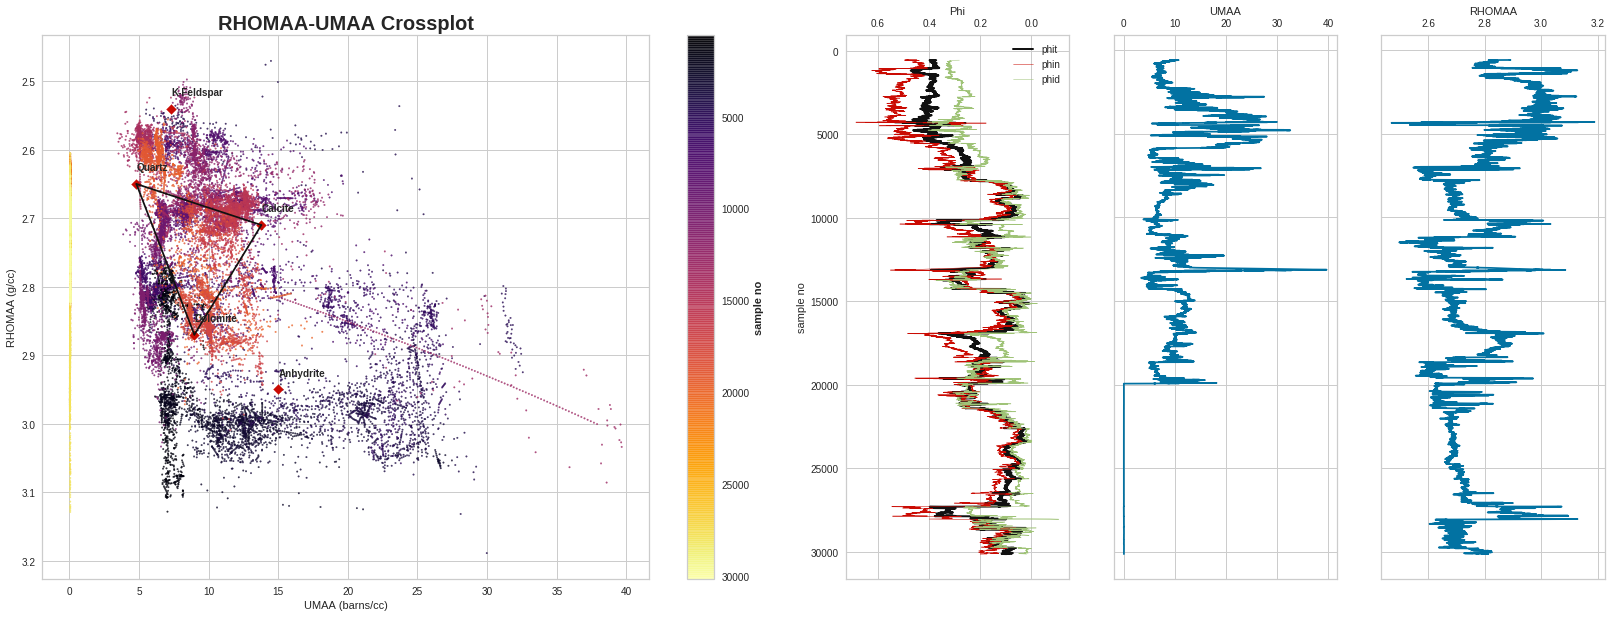

In [64]:
fig,_,_ = plot_rhomaa_umaa(df_clean['PE'].interpolate(limit_area='inside'), df_clean['ZDEN'].interpolate(limit_area='inside'), df_clean['CNC'].interpolate(limit_area='inside'))
plt.show()

The filtering operation has done a good job of removing outliers while keeping the overall signal intact

PE definitely has some bad values, as evident both on the log plot and the RHOMAA-UMAA transform crossplot.

**CAL seems a little suspect, though.  It seems unusual for CAL to increase at the bottom of the hole**

In fact, CAL and PE basically go bad at the same sample number, so it is likely they had a shared tool failure

There are several ways to proceed.

A few observations:

* CAL could be useful (variations in the wellbore are related to geomechanical properties), but it can also be rather stationary.
* If we want to maximize the amount of data available for estimating DTC & DTS, then interpolation is necessary.
* The last 10,000 samples in the PE curve appear to be bogus.  Maybe these can be estimated using the shallower section?
* HRM (Medium Resisitivity) should be dropped.  Without knowing the depth of investigation, it is likely to be contaminated with well-bore fluids.  HRD (Deep Resisitivity) is the better resistivity curve to use.  Maybe we could calculate Rt?

In [65]:
plt.rcParams["axes.labelsize"] = 20

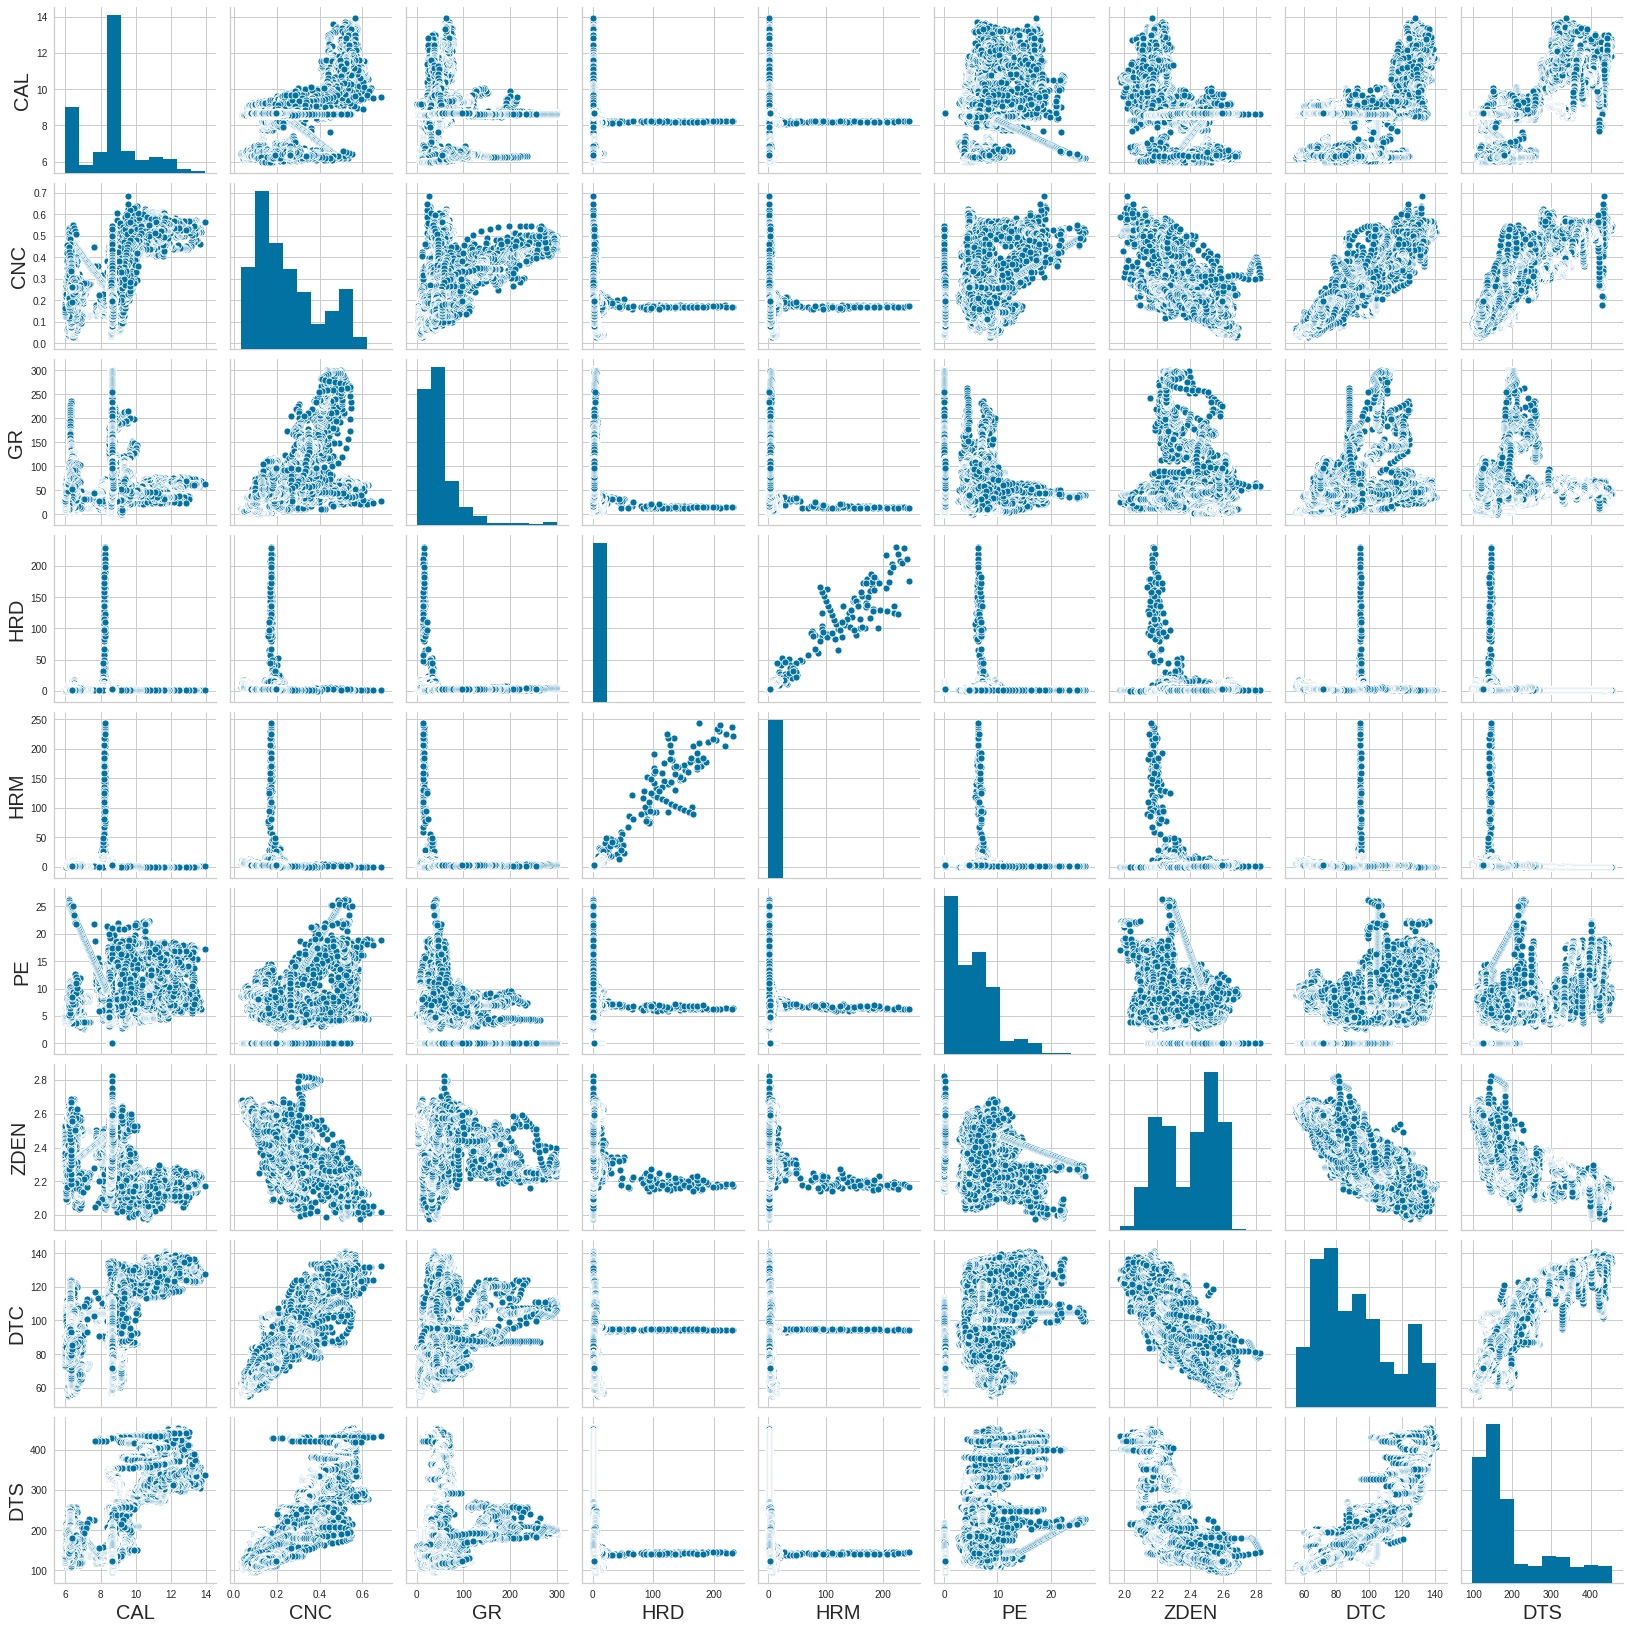

In [66]:
sns.pairplot(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False))
plt.show()

Several predictors exhibit a degree of multicollinearity

* CNC & GR, which also exhibits heteroscedasticity
* CNC & ZDEN
* HRM & HRD

Feature ranking will be an important step

PCA may also be useful

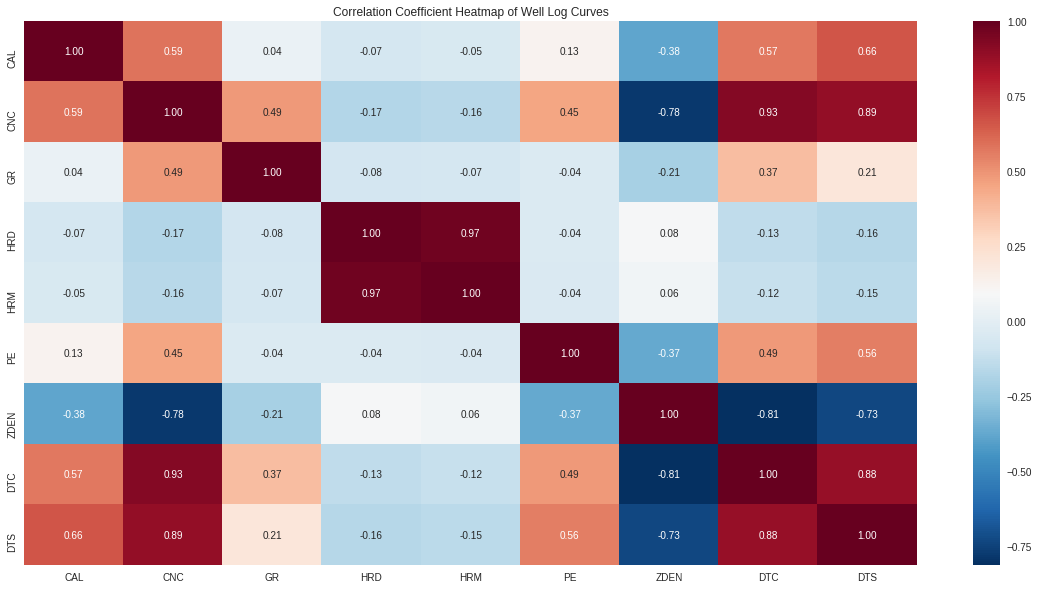

In [67]:
fig = plt.figure(figsize=(20,10))
ax = sns.heatmap(df_clean.interpolate(limit_area='inside').dropna(axis=0, inplace=False).corr(), cmap="RdBu_r", annot=True, fmt=".2f")
ax.set_title('Correlation Coefficient Heatmap of Well Log Curves')
plt.show()

Observations:

* CAL has reasonably high positive correlation to both DTC & DTS, as well as CNC.
* CNC has reasonably high positive correlation to CAL, GR, PE, as well as to DTC & DTS
* GR has moderate positive correlation to DTC & DTS
* HRD & HRM do not exhibit strong correlation with any other parameters than themselves, *but this could be due to the fact they are log-scale*
* PE has moderately positive correlation with CNC, DTC, & DTS
* ZDEN has a high negative correlation with CNC, DTC, & DTS, and mild negative correlation with CAL, GR, & PE

The recommendation going forward will be to drop CAL & HRM from the set of inputs.

## <a name="imputing"></a> 5. Imputing Missing Data

Back to [top](#top)

Before proceeding to estimating DTC & DTS, if we want to use as much of the data as possible, we need to attempt to estimate the bad values for PE.

1. [5a. PE Curve Estimation](#fe-pe)

**But first, create df_subset which will be our starting point for imputing values**

1. Drop 'CAL' & 'HRM'

1. Find NaN index values for DTC & DTS

1. Interpolate to fill all gaps, then remove interpolated values for DTC & DTS

1. Remove bad PE values and replace with NaN

In [68]:
df_subset = df_clean.copy().drop(labels=['CAL','HRM'], axis=1)

In [69]:
dtc_nans = consecutive_nans(df_subset.index, df_subset['DTC'], threshold=100)
dts_nans = consecutive_nans(df_subset.index, df_subset['DTS'], threshold=100)

In [70]:
dtc_nans

range(9071, 13126)

In [71]:
dts_nans

range(4104, 8901)

Visually QC dtc_nans & dts_nans

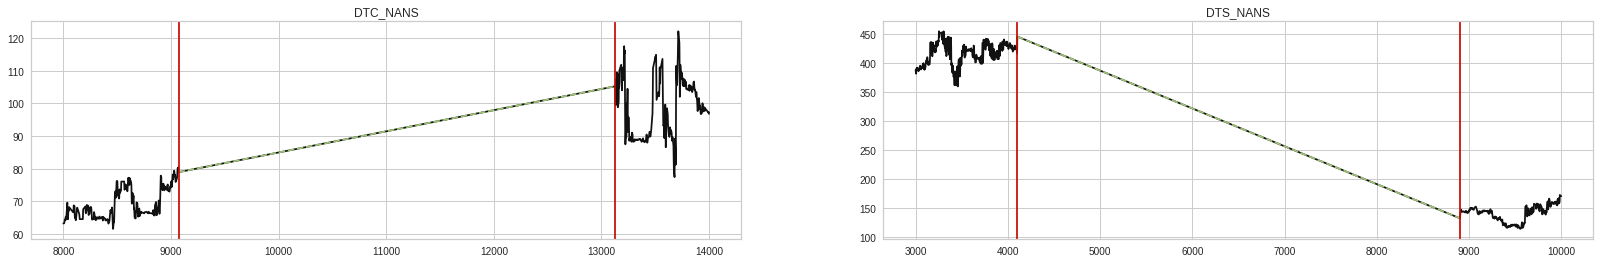

In [72]:
fig = plt.figure(figsize=(28,4))

ax1 = fig.add_subplot(121)
ax1.plot(df_subset['DTC'].interpolate(limit_area='inside').iloc[8000:14000], 'k')
ax1.plot(df_subset.interpolate(limit_area='inside').dropna(axis=0)['DTC'].loc[dtc_nans], '--g')
ax1.axvline(dtc_nans[0], ymin=0, ymax=140, c='r')
ax1.axvline(dtc_nans[-1], ymin=0, ymax=140, c='r')
ax1.set_title('DTC_NANS')

ax2 = fig.add_subplot(122)
ax2.plot(df_subset['DTS'].interpolate(limit_area='inside').iloc[3000:10000], 'k')
ax2.plot(df_subset.interpolate(limit_area='inside').dropna(axis=0).loc[dts_nans,'DTS'], '--g')
ax2.axvline(dts_nans[0], ymin=0, ymax=500, c='r')
ax2.axvline(dts_nans[-1], ymin=0, ymax=500, c='r')
ax2.set_title('DTS_NANS')

plt.show()

In [73]:
df_subset = df_subset.interpolate(limit_area='inside')
df_subset = df_subset.dropna()
df_subset.loc[dtc_nans,'DTC'] = np.nan # use loc since we have dropped rows and iloc no longer equals loc
df_subset.loc[dts_nans,'DTS'] = np.nan

In [74]:
df_subset[df_subset['PE'] < 1].head(1)

CNC       GR     HRD     PE    ZDEN      DTC       DTS
19939  0.2689  41.2673  1.1991  0.049  2.1834  91.1456  185.8183

In [75]:
df_subset.loc[19939:,'PE'] = np.nan
pe_nans = consecutive_nans(df_subset.index, df_subset['PE'], threshold=1000)

In [76]:
df_subset.reset_index(drop=True, inplace=True)

In [77]:
df_subset.describe().transpose()

count        mean        std      min         25%         50%  \
CNC   29550.0    0.245812   0.148303   0.0315    0.129800    0.198488   
GR    29550.0   46.867002  44.807744   0.0000   16.588850   37.496694   
HRD   29550.0    2.861479   8.280165   0.1295    0.722125    1.584667   
PE    19361.0    7.680453   3.478978   2.6803    5.031600    6.991150   
ZDEN  29550.0    2.393974   0.166965   1.9769    2.236662    2.438875   
DTC   25495.0   91.055340  23.799113  55.4076   71.485124   83.461300   
DTS   24753.0  177.410474  78.520700  96.9005  130.399914  143.039473   

             75%       max  
CNC     0.333054    0.6868  
GR     57.555233  299.9302  
HRD     3.108196  231.2297  
PE      8.848800   26.3707  
ZDEN    2.549461    2.8262  
DTC   109.622800  141.0543  
DTS   189.284956  455.3579

In [78]:
df_subset.head()

CNC         GR     HRD      PE    ZDEN       DTC       DTS
0  0.4633  60.081839  1.8688  6.6753  2.1849  126.5374  305.9166
1  0.4821  60.043330  1.7827  6.6690  2.1394  127.0895  309.3540
2  0.4821  60.004822  1.7049  6.5535  2.1370  127.4648  312.7448
3  0.4689  59.966313  1.6703  6.6136  2.1395  127.6743  315.0485
4  0.4865  59.927804  1.6453  6.6984  2.1377  127.7576  316.3320

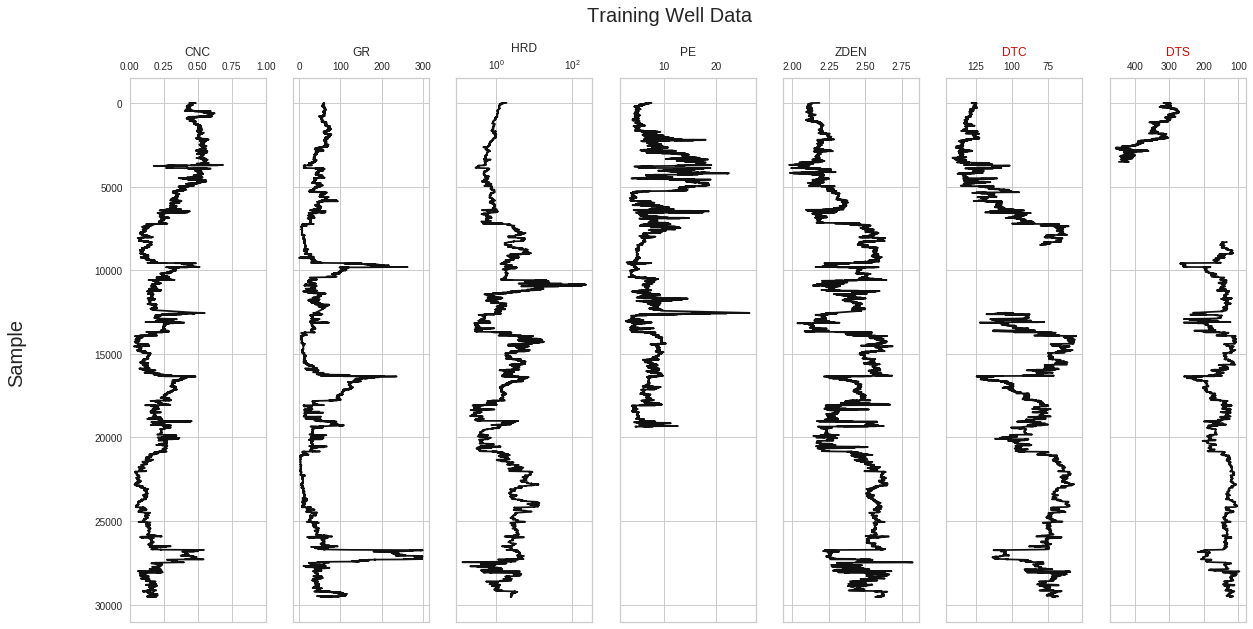

In [79]:
plot_well_curves(df_subset)
plt.show()

Re-set nan indexes for DTC, DTS, & PE now that the index values have been reset

In [80]:
dtc_nans = consecutive_nans(df_subset.index, df_subset['DTC'], threshold=100)
dts_nans = consecutive_nans(df_subset.index, df_subset['DTS'], threshold=100)
pe_nans = consecutive_nans(df_subset.index, df_subset['PE'], threshold=1000)

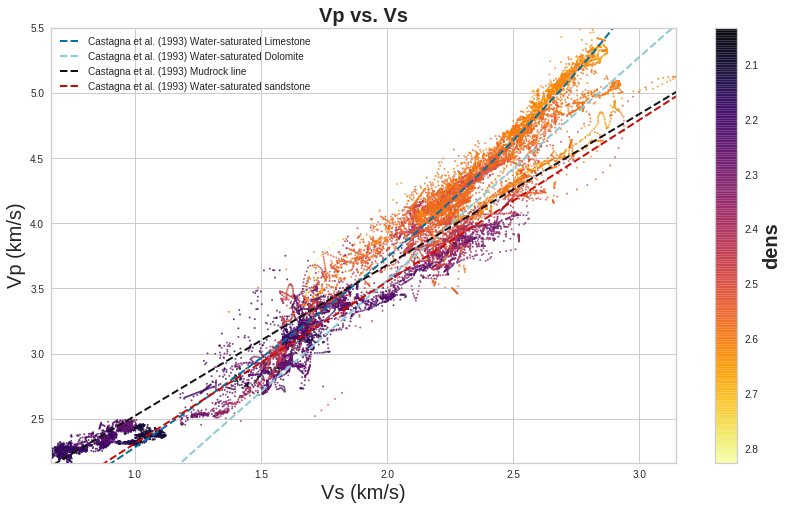

In [81]:
plot_vp_vs(x='DTC', y='DTS', color='ZDEN', df=df_subset)
plt.show()

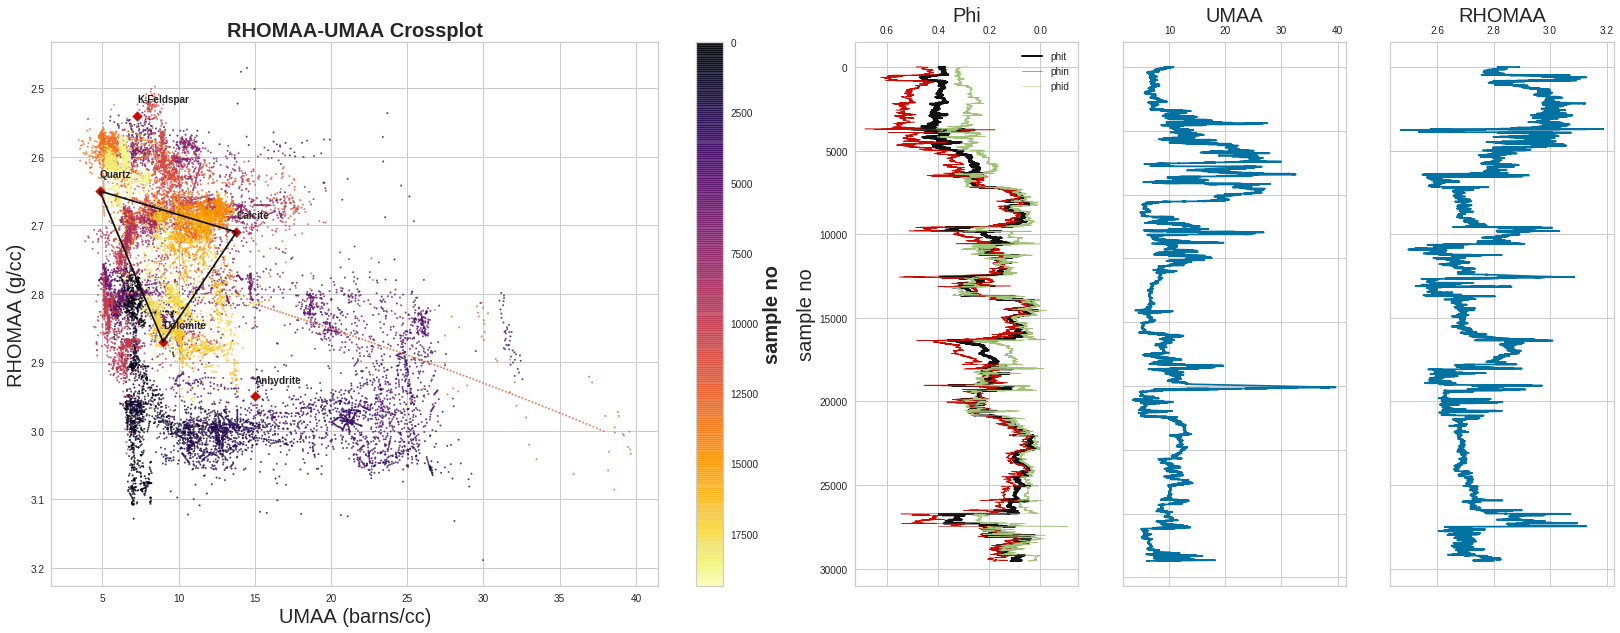

In [82]:
plot_rhomaa_umaa(df_subset['PE'], df_subset['ZDEN'], df_subset['CNC'])
plt.show()

### <a name="fe-pe"></a> 5a. Imputing Missing Data - PE Curve Estimation

Back to [top](#top)

The goal is to estimate PE for the final 10,000 samples that appear to have a bad measurement.

If we can robustly estimate the PE curve that appears to be usable, then we can splice in the estimated section for the bad data samples, keeping the good data.

We previously observed that CNC & ZDEN were most correlated to PE, so take a closer look.

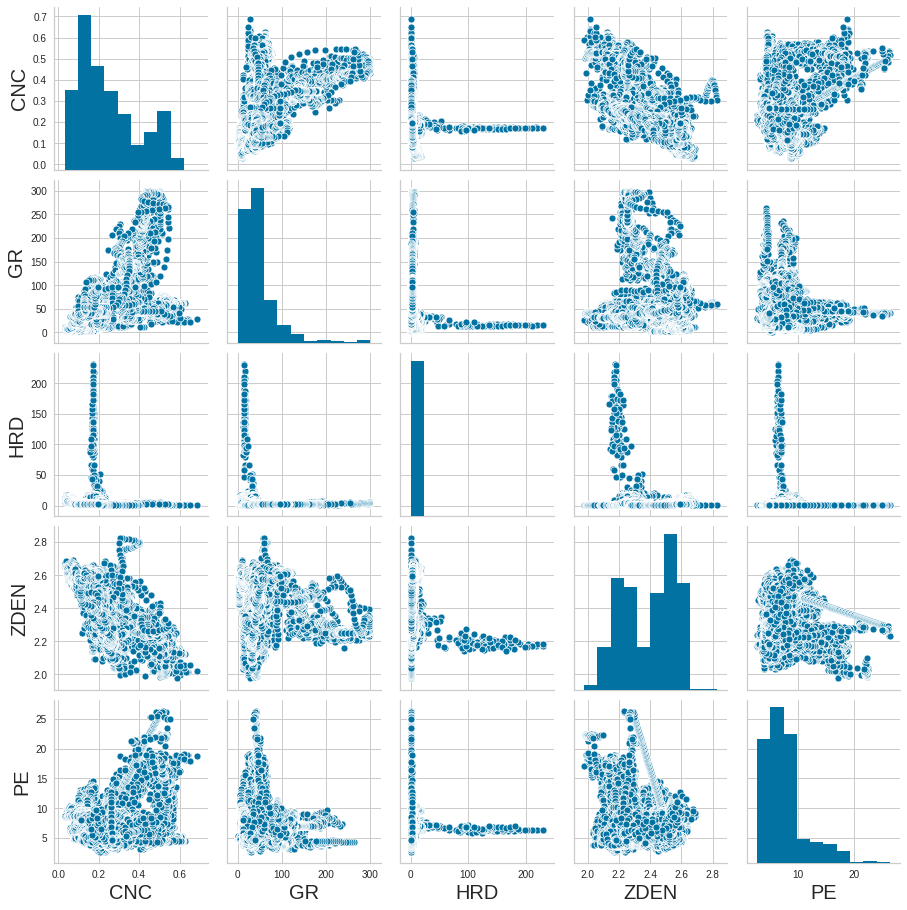

In [83]:
sns.pairplot(df_subset[['CNC','GR','HRD','ZDEN','PE']])

It is also worth crossplotting PE and HRD using a semilog scale to see if there is any relation not immediately noticeable in linear scale

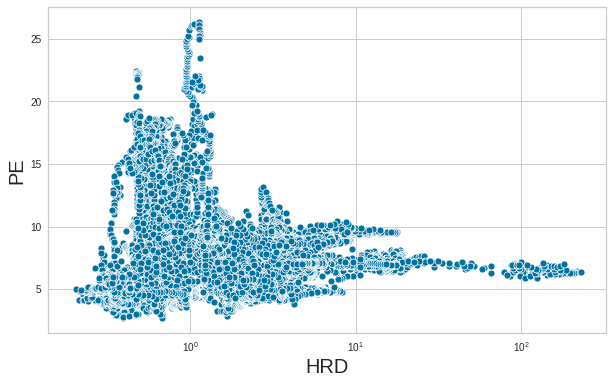

In [84]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax = sns.scatterplot(x='HRD', y='PE', data=df_subset)
ax.set_xscale('log')
plt.show()

It looks like there is more meaningful information in HRD if it is plotted in logspace

Use pe_nans to check the point at which PE values appear to go consistently bad.  We can use all data up to this point for attempting to estimate PE.

In [85]:
pe_nans

range(19361, 29549)

In [86]:
df_pe = df_subset[['GR','CNC','HRD','ZDEN','PE']].iloc[0:19361].copy()

In [87]:
df_pe['HRD'] = df_pe['HRD'].apply(np.log)
df_pe.rename(columns={'HRD':'log_HRD'}, inplace=True)

QC this subselection

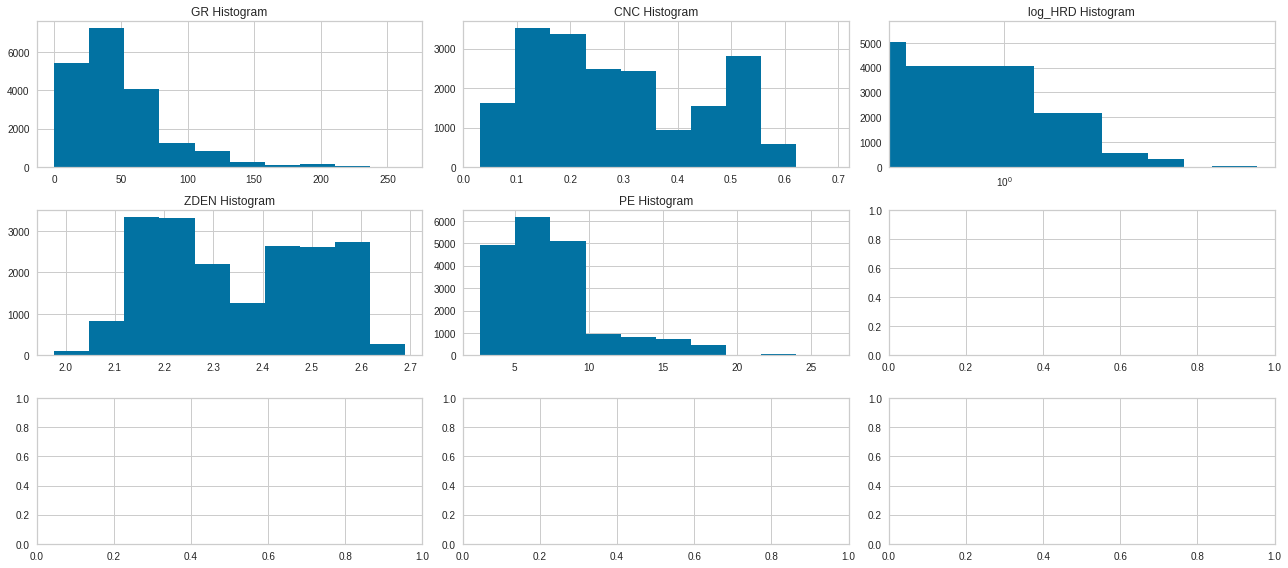

In [88]:
plot_data_distributions(df_pe)
plt.show()

In [89]:
df_pe.describe().transpose()

count       mean        std       min        25%        50%  \
GR       19361.0  47.407831  35.309062  0.000000  23.319100  40.083247   
CNC      19361.0   0.287142   0.154101  0.031500   0.158100   0.253062   
log_HRD  19361.0   0.283833   0.971738 -1.589635  -0.433556   0.106160   
ZDEN     19361.0   2.348163   0.162348  1.976900   2.198300   2.324214   
PE       19361.0   7.680453   3.478978  2.680300   5.031600   6.991150   

               75%         max  
GR       61.122100  263.089500  
CNC       0.430350    0.686800  
log_HRD   0.858407    5.443412  
ZDEN      2.495133    2.688900  
PE        8.848800   26.370700

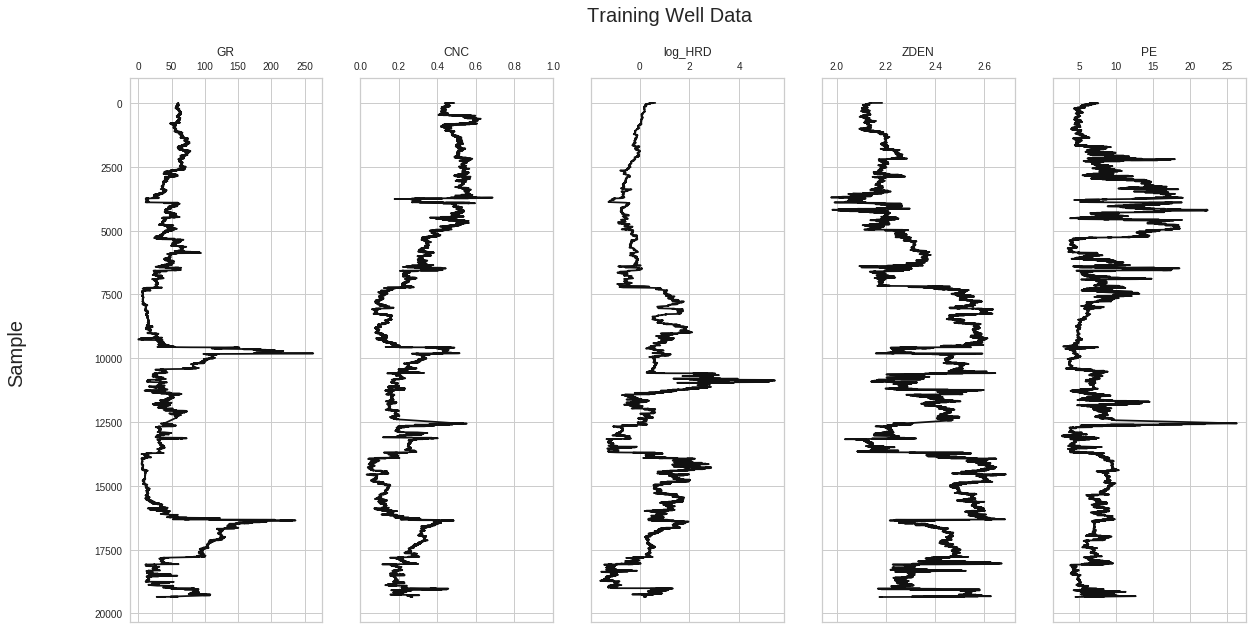

In [90]:
plot_well_curves(df_pe)
plt.show()

**Ok!  This looks like we have a valid subset of data for imputing PE**

1. Train-Test-Split
1. StandardScaler
1. Investigate Feature Selection
  1. Univariate Statistics using SelectPercentile
  1. Iterative Feature Selection using Recursive Feature Elimination
1. Model Selection using cross_val_score
  1. Linear: Linear Regression, Ridge, Lasso
  1. Ensemble: Random Forest
1. GridSearchCV for hyperparameter tuning using best model from cross_val_score
1. QC real vs. predicted PE
1. Splice predicted data in for bad data, keeping good data

#### **1. Split the data into train and test sets**

In [91]:
Xpe_train, Xpe_test, ype_train, ype_test = train_test_split(df_pe[['GR','CNC','log_HRD','ZDEN']], df_pe['PE'], test_size=0.2, random_state=random_state)

#### **2. Instantiate, fit, and transform using StandardScaler**

In [92]:
scaler_pe = StandardScaler()

In [93]:
scaler_pe.fit(Xpe_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [94]:
Xpe_train_scaled = scaler_pe.transform(Xpe_train)
Xpe_test_scaled = scaler_pe.transform(Xpe_test)

In [95]:
print('Xpe_train_scaled shape: {}'.format(Xpe_train_scaled.shape))
print('Xpe_test_scaled shape: {}'.format(Xpe_test_scaled.shape))

Xpe_train_scaled shape: (15488, 4)
Xpe_test_scaled shape: (3873, 4)


#### **3. Investigate Feature Selection**

Test for [multicollinearity](https://stackoverflow.com/a/25833792/12951266)

In [96]:
# calculate the correlation matrix
corr = np.corrcoef(Xpe_train_scaled, rowvar=0)

In [97]:
# inspect the correlation coefficients
corr

array([[ 1.        ,  0.45765668, -0.06014388, -0.13174308],
       [ 0.45765668,  1.        , -0.49662176, -0.75007272],
       [-0.06014388, -0.49662176,  1.        ,  0.6121473 ],
       [-0.13174308, -0.75007272,  0.6121473 ,  1.        ]])

In [98]:
# calculate the Eigenvalues, w, and Eigenvectors, v
w, v = np.linalg.eig(corr)

In [99]:
# Inspect the Eigenvalues for near-zero
w

array([2.35492817, 1.02726774, 0.17293724, 0.44486685])

None of the Eignevalues are very close to zero.  Calcuate [Variance Inflation Factor](https://etav.github.io/python/vif_factor_python.html), *VIF*, using statsmodels to be certain

In [100]:
# For each X, calculate VIF and save in a new dataframe
vif = pd.DataFrame()
Xpe_train_scaled_wconst = np.hstack((Xpe_train_scaled, np.ones(Xpe_train_scaled[:,:1].shape))) # add in a constant
vif['VIF Factor'] = [variance_inflation_factor(Xpe_train_scaled_wconst, i) for i in range(Xpe_train_scaled_wconst.shape[1])]
feats = df_pe.columns.to_list()[:-1]
feats.append('Constant')
vif['Features'] = feats

In [101]:
vif

VIF Factor  Features
0    1.461930        GR
1    3.299062       CNC
2    1.617465   log_HRD
3    3.049948      ZDEN
4    1.000000  Constant

VIF can also be calculated by taking the [Diagonal of the inverse of the Correlation Coefficient](https://stackoverflow.com/a/51463149/12951266)

In [102]:
vif_corr = np.linalg.inv(corr)

In [103]:
vif_corr.diagonal()

array([1.46192985, 3.29906249, 1.61746493, 3.04994829])

All VIF Factors are below 10 so we should be safe from severe multicollinearity.  It is obvious that CNC & ZDEN dispaly collinearity, but we do not wish to drop them at this time.

Check the standardized features visually using a pairplot:

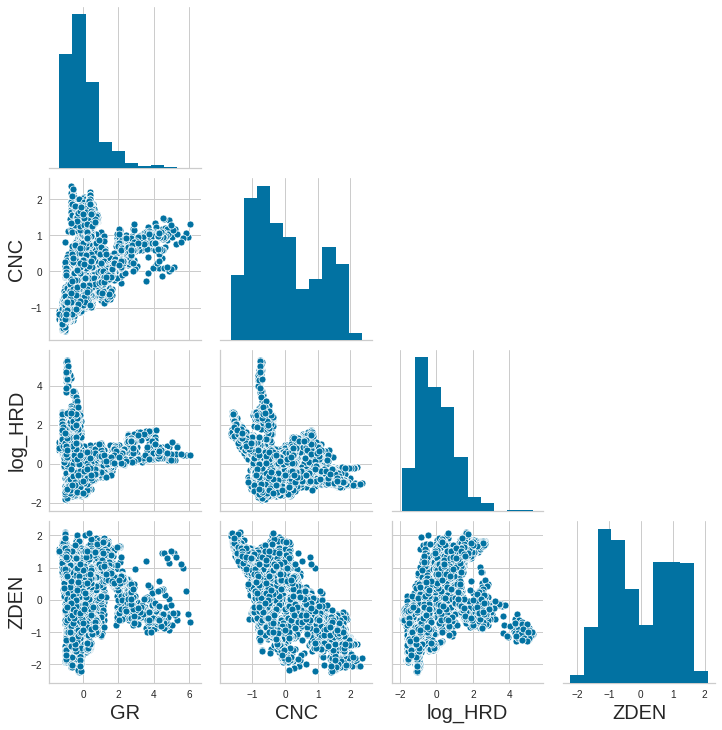

In [104]:
sns.pairplot(pd.DataFrame(Xpe_train_scaled, columns=df_pe.columns.to_list()[:-1]), corner=True)

##### **A. Univariate Feature Selection with SelectPercentile**

In [105]:
select_pe = SelectPercentile(f_regression, percentile=75)
select_pe.fit(Xpe_train_scaled, ype_train)

SelectPercentile(percentile=75,
                 score_func=<function f_regression at 0x7efbdad2f680>)

In [106]:
Xpe_train_scaled_selected = select_pe.transform(Xpe_train_scaled)

In [107]:
Xpe_train_scaled_selected.shape

(15488, 3)

In [108]:
mask = select_pe.get_support()
print('Selected Features: {}'.format(np.array(df_pe.columns.to_list()[:-1])[mask]))

Selected Features: ['GR' 'CNC' 'ZDEN']


This is not a terribly surprising result, but comforting that the method works as expected.

In [109]:
select_pe.scores_

array([ 318.87508741, 1364.82001775,  178.72493414,  329.85563508])

CNC has the highest score, followed by ZDEN and GR.

In [110]:
select_pe.pvalues_

array([1.29900403e-070, 2.11522801e-286, 1.54366558e-040, 5.90169586e-073])

##### **B. Iterative Feature Selection using RFE**

In [111]:
select_rfe_pe = RFE(RandomForestRegressor(random_state=random_state), n_features_to_select=3)
select_rfe_pe.fit(Xpe_train_scaled, ype_train)

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=42, verbose=0,
                                    warm_start=False),
    n_features_to_select=3, step=1, verbose=0)

In [112]:
mask = select_rfe_pe.get_support()
print('Selected Features : {}'.format(np.array(df_pe.columns.to_list()[:-1])[mask]))

Selected Features : ['GR' 'CNC' 'log_HRD']


*Interesting ... RFE has selected GR, CNC, and log_HRD as the three most important features, discarding ZDEN*

In [113]:
select_rfe_pe.ranking_

array([1, 1, 1, 2])

In [114]:
print('Test Score using RFE selected Features: {:.3f}'.format(select_rfe_pe.score(Xpe_test_scaled, ype_test)))
print('Test Score using SelectPercentile Features: {:.3f}'.format(RandomForestRegressor(random_state=random_state).fit(Xpe_train_scaled_selected, ype_train).score(select_pe.transform(Xpe_test_scaled), ype_test)))

Test Score using RFE selected Features: 0.895
Test Score using SelectPercentile Features: 0.864


**Without any additional tuning, the RFR fit with the features selected using RFE performs better than the RFR fit with SelectPercentile features.**

In [115]:
Xpe_train_scaled_rfe = select_rfe_pe.transform(Xpe_train_scaled)
Xpe_test_scaled_rfe = select_rfe_pe.transform(Xpe_test_scaled)

In [116]:
rfe_features = np.array(df_pe.columns.to_list()[:-1])[mask]

Plot RFE Selected Feature Importance using Yellowbrick

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


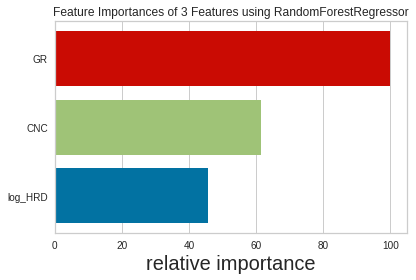

In [117]:
viz = FeatureImportances(RandomForestRegressor(random_state=random_state), labels=rfe_features)
viz.fit(Xpe_train_scaled_rfe, ype_train)
viz.show()

##### **4. Model Selection using K-folds Cross Validation**

Use k-folds CV to test several models without hyperparameter tuning.  The best performing model will be selected and then tuned using GridSearchCV

In [118]:
lr = LinearRegression()
ridge = Ridge(random_state=random_state)
lasso = Lasso(random_state=random_state)
svr = SVR()
rfr = RandomForestRegressor(random_state=random_state)
gbt = GradientBoostingRegressor(random_state=random_state)

In [119]:
estimator_dict = {
    'LinearRegression' : lr,
    'Ridge' : ridge,
    'Lasso' : lasso,
    'SVR' : svr,
    'RandomForestRegressor' : rfr,
    'GradientBoostingRegressor' : gbt,
}

In [120]:
for key in estimator_dict.keys():
    print('Performing 5-fold Cross Validation using {} estimator ...\n'.format(key))
    scores = cross_val_score(estimator_dict[key], Xpe_train_scaled_rfe, ype_train, cv=5)
    print('5-fold Cross-Validation scores: {}'.format(scores))
    print('Average cross-validation score: {}'.format(scores.mean()))
    print('\n')

Performing 5-fold Cross Validation using LinearRegression estimator ...

5-fold Cross-Validation scores: [0.19821669 0.17071405 0.19657754 0.1806277  0.18273563]
Average cross-validation score: 0.18577432089947607


Performing 5-fold Cross Validation using Ridge estimator ...

5-fold Cross-Validation scores: [0.19821058 0.17071802 0.19657661 0.18062842 0.1827391 ]
Average cross-validation score: 0.1857745469924542


Performing 5-fold Cross Validation using Lasso estimator ...

5-fold Cross-Validation scores: [-3.93289726e-04  1.71521618e-03 -9.19572556e-05 -1.82076157e-05
 -4.21803424e-04]
Average cross-validation score: 0.0001579916310623597


Performing 5-fold Cross Validation using SVR estimator ...

5-fold Cross-Validation scores: [0.51221892 0.51727616 0.5753639  0.50445273 0.53829848]
Average cross-validation score: 0.5295220372925243


Performing 5-fold Cross Validation using RandomForestRegressor estimator ...

5-fold Cross-Validation scores: [0.88818158 0.88028013 0.88981381 0

**Some observations:**

1. The linear models (Linear Regression, Ridge, Lasso) all perform poorly without hyperparameter tuning.  Adding feature interactions likely would help, but may not be worth the time spent.

1. Support Vector Machine Regressor performs significantly better than the linear models.  Hyperparameter tuning could produce a robust model.

1. Random Forest Regressor performs the best out-of-the-box without any tuning.

1. Gradient Boosting Regressor performs better than SVR, but not as well as RFR.  With tuning, it could produce a robust model.

***Lets proceed with tuning RandomForestRegressor***

Instantiate a new RandomForestRegressor

In [121]:
rfr_pe = RandomForestRegressor(random_state=random_state)

In [122]:
print('Initial Parameters:\n')
pprint(rfr_pe.get_params())

Initial Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Define the parameter grid for GridSearchCV

In [129]:
rf_pe_param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=2000, num=20)],
    'max_features': [1, 2],
    'max_depth': [10,50,100,None],
}

In [130]:
print('Parameter Grid:\n{}'.format(rf_pe_param_grid))

Parameter Grid:
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'max_features': [1, 2], 'max_depth': [10, 50, 100, None]}


Instantiate & Fit the GridSearchCV

In [131]:
rf_pe_grid_search = GridSearchCV(rfr_pe, rf_pe_param_grid, n_jobs=-1, cv=5, verbose=1)

In [132]:
rf_pe_grid_search.fit(Xpe_train_scaled_rfe, ype_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 64.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 65.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [133]:
print('Best Parameters: {}'.format(rf_pe_grid_search.best_params_))

Best Parameters: {'max_depth': 50, 'max_features': 2, 'n_estimators': 800}


In [134]:
print('Best CV Score: {}'.format(rf_pe_grid_search.best_score_))

Best CV Score: 0.88220250515317


This represents the mean CV score for the best estimator on the left out data for the 5-folds

In [135]:
print('Train score using grid search best estimator: {:.3f}'.format(rf_pe_grid_search.score(Xpe_train_scaled_rfe, ype_train)))

Train score using grid search best estimator: 0.985


In [136]:
print('Test score from grid search: {:.3f}'.format(rf_pe_grid_search.score(Xpe_test_scaled_rfe, ype_test)))

Test score from grid search: 0.901


There is some degradation between the Train & Test score suggesting an overfit model, although not bad.

Let's inspect the GridSearchCV results in a little more detail

In [137]:
results_rf_pe_gs = pd.DataFrame(rf_pe_grid_search.cv_results_)

In [155]:
display(results_rf_pe_gs.head())

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.927108      0.012439         0.031545        0.000523   
1       1.818930      0.010682         0.060719        0.000359   
2       2.732921      0.015377         0.091219        0.001246   
3       3.637595      0.015948         0.120297        0.000569   
4       4.536383      0.027607         0.149994        0.000649   

  param_max_depth param_max_features param_n_estimators  \
0              10                  1                100   
1              10                  1                200   
2              10                  1                300   
3              10                  1                400   
4              10                  1                500   

                                              params  split0_test_score  \
0  {'max_depth': 10, 'max_features': 1, 'n_estima...           0.827133   
1  {'max_depth': 10, 'max_features': 1, 'n_estima...           0.827482   
2  {'max_depth': 10, 'max_features': 1, 'n_estima...           0.828002   
3  {'max_depth': 10, 'max_features': 1, 'n_estima...           0.828364   
4  {'max_depth': 10, 'max_features': 1, 'n_estima...           0.828638   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.821552           0.837086           0.804275           0.805587   
1           0.820848           0.834728           0.802738           0.805761   
2           0.820563           0.836282           0.803551           0.806691   
3           0.820491           0.836668           0.803577           0.807665   
4           0.820280           0.836845           0.804387           0.807740   

   mean_test_score  std_test_score  rank_test_score  
0         0.819127        0.012621              156  
1         0.818311        0.012330              160  
2         0.819018        0.012429              159  
3         0.819353        0.012392              146  
4         0.819578        0.012261              143

Access the results from the best CV score

In [139]:
results_rf_pe_gs.iloc[rf_pe_grid_search.best_index_]

mean_fit_time                                                   19.9747
std_fit_time                                                   0.316648
mean_score_time                                                0.557643
std_score_time                                               0.00405241
param_max_depth                                                      50
param_max_features                                                    2
param_n_estimators                                                  800
params                {'max_depth': 50, 'max_features': 2, 'n_estima...
split0_test_score                                              0.893274
split1_test_score                                              0.886595
split2_test_score                                              0.893679
split3_test_score                                              0.869691
split4_test_score                                              0.867773
mean_test_score                                                0

In [140]:
np.array(results_rf_pe_gs['mean_test_score']).shape

(160,)

In [148]:
scores_rf_pe_gs = np.array(results_rf_pe_gs.mean_test_score).reshape(4,2,20)

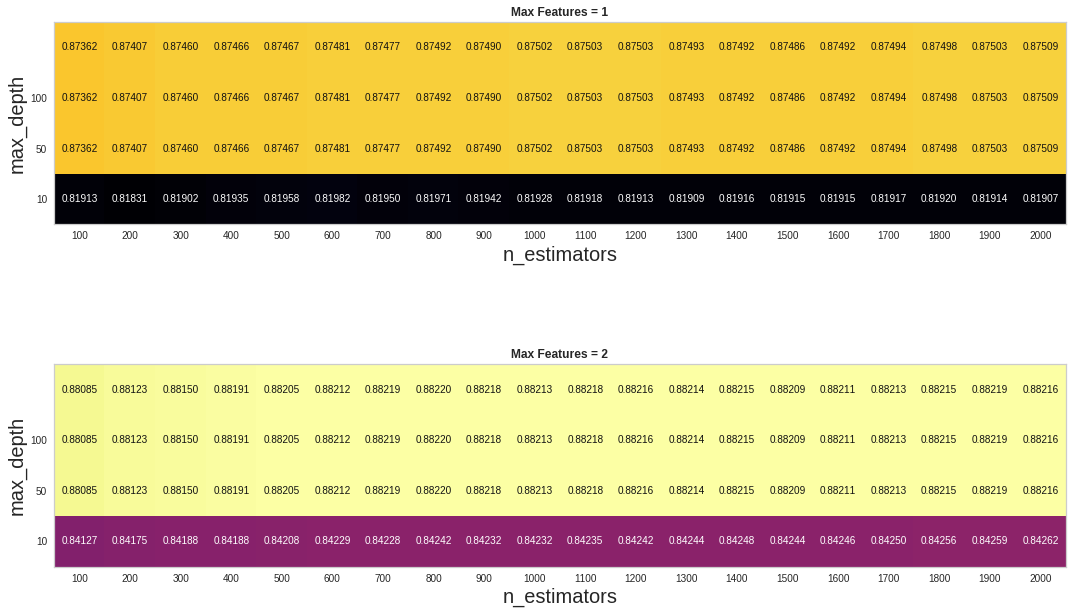

In [162]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

heatmap(scores_rf_pe_gs[:,0,:], xlabel='n_estimators', xticklabels=rf_pe_param_grid['n_estimators'],
        ylabel='max_depth', yticklabels=rf_pe_param_grid['max_depth'],
        cmap='inferno', ax=ax[0], vmin=np.nanmin(scores_rf_pe_gs), vmax=np.nanmax(scores_rf_pe_gs), fmt='%0.5f')
ax[0].set_title('Max Features = 1', fontweight='bold')
heatmap(scores_rf_pe_gs[:,1,:], xlabel='n_estimators', xticklabels=rf_pe_param_grid['n_estimators'],
        ylabel='max_depth', yticklabels=rf_pe_param_grid['max_depth'],
        cmap='inferno', ax=ax[1], vmin=np.nanmin(scores_rf_pe_gs), vmax=np.nanmax(scores_rf_pe_gs), fmt='%0.5f')
ax[1].set_title('Max Features = 2', fontweight='bold')

fig.tight_layout()
plt.show()

**Visualize the results:**

1. Training Set

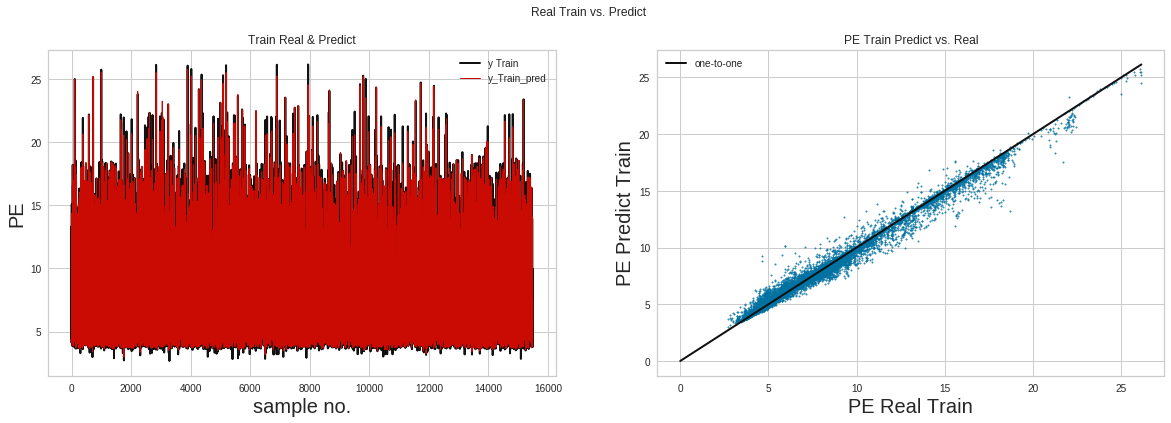

In [163]:
plot_real_vs_pred(ype_train, rf_pe_grid_search.predict(Xpe_train_scaled_rfe), feat_name='PE', split='Train')
plt.show()

2. Testing Set

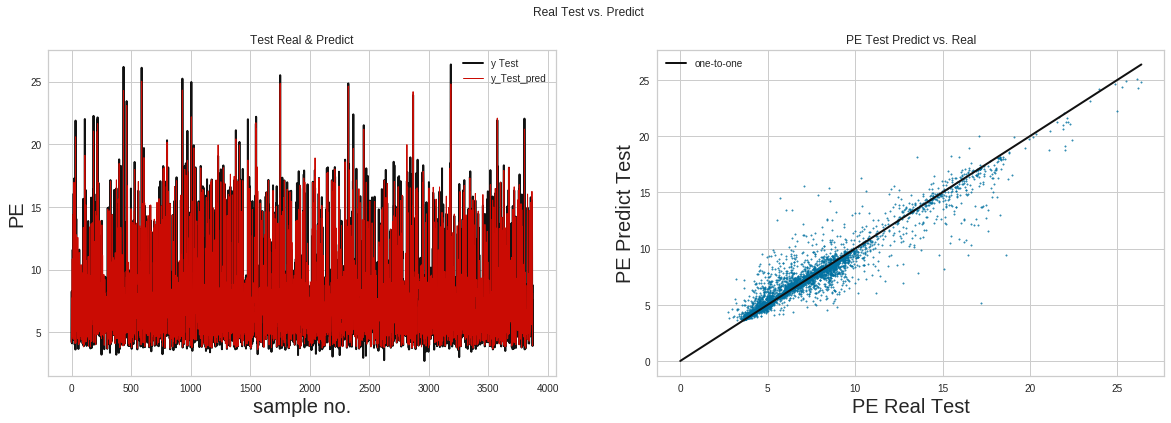

In [164]:
plot_real_vs_pred(ype_test, rf_pe_grid_search.predict(Xpe_test_scaled_rfe), feat_name='PE', split='Test')
plt.show()

3. Full Train/Test Set

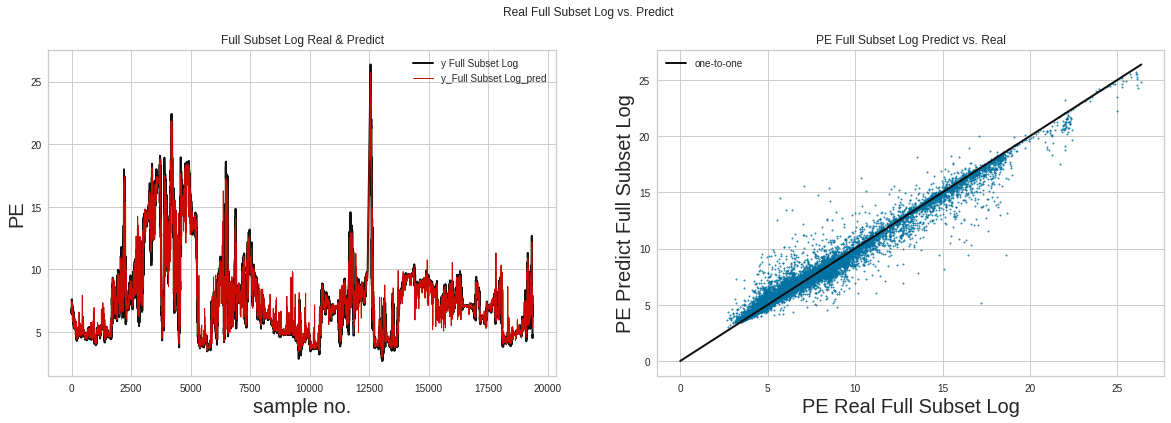

In [165]:
plot_real_vs_pred(df_pe['PE'], rf_pe_grid_search.predict(select_rfe_pe.transform(scaler_pe.transform(df_pe[['GR','CNC','log_HRD','ZDEN']]))), feat_name='PE', split='Full Subset Log')
plt.show()

4. Full Log, predicting beyond the end of real data

In [169]:
df_subset['log_HRD'] = df_subset['HRD'].apply(np.log)

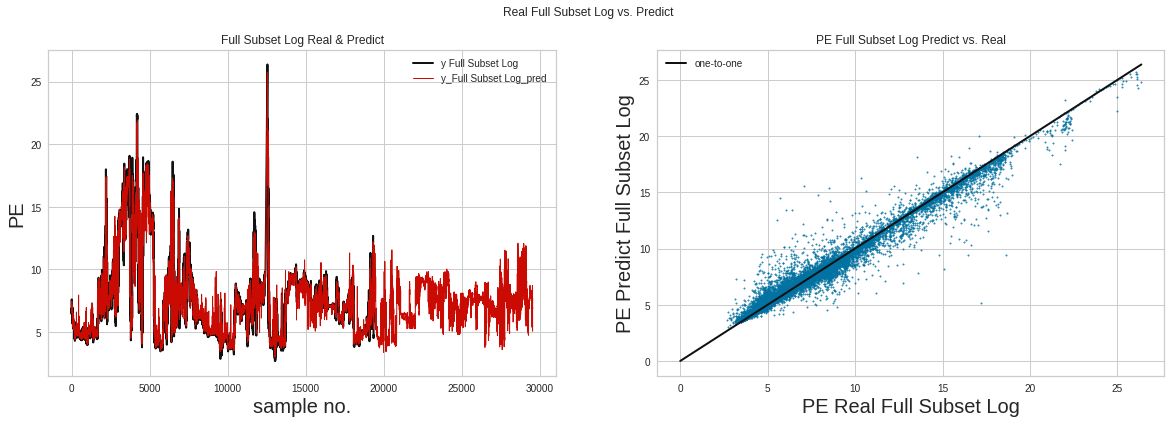

In [170]:
plot_real_vs_pred(df_subset['PE'],
                  rf_pe_grid_search.predict(select_rfe_pe.transform(scaler_pe.transform(df_subset[['GR','CNC','log_HRD','ZDEN']]))),
                  feat_name='PE', split='Full Subset Log')
plt.show()

Splice the predicted data into the PE log

In [171]:
df_subset['PE_est'] = df_subset['PE']
df_subset['PE_est'].loc[pe_nans] = rf_pe_grid_search.predict(select_rfe_pe.transform(scaler_pe.transform(df_subset[['GR','CNC','log_HRD','ZDEN']])))[pe_nans]

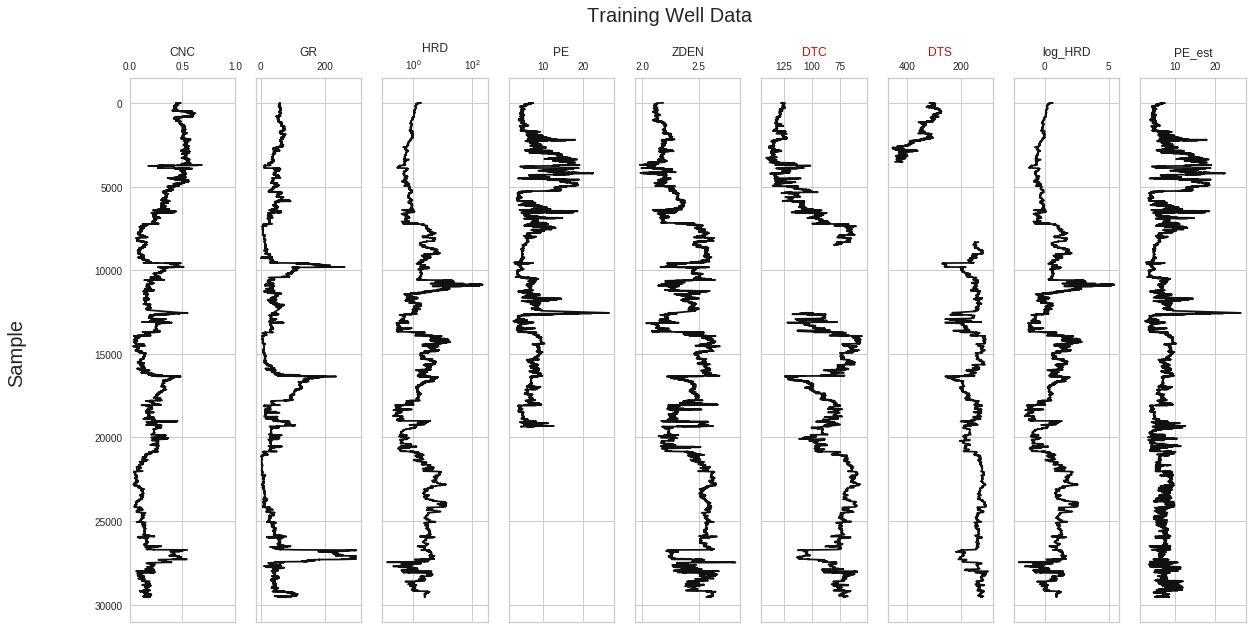

In [172]:
plot_well_curves(df_subset)
plt.show()

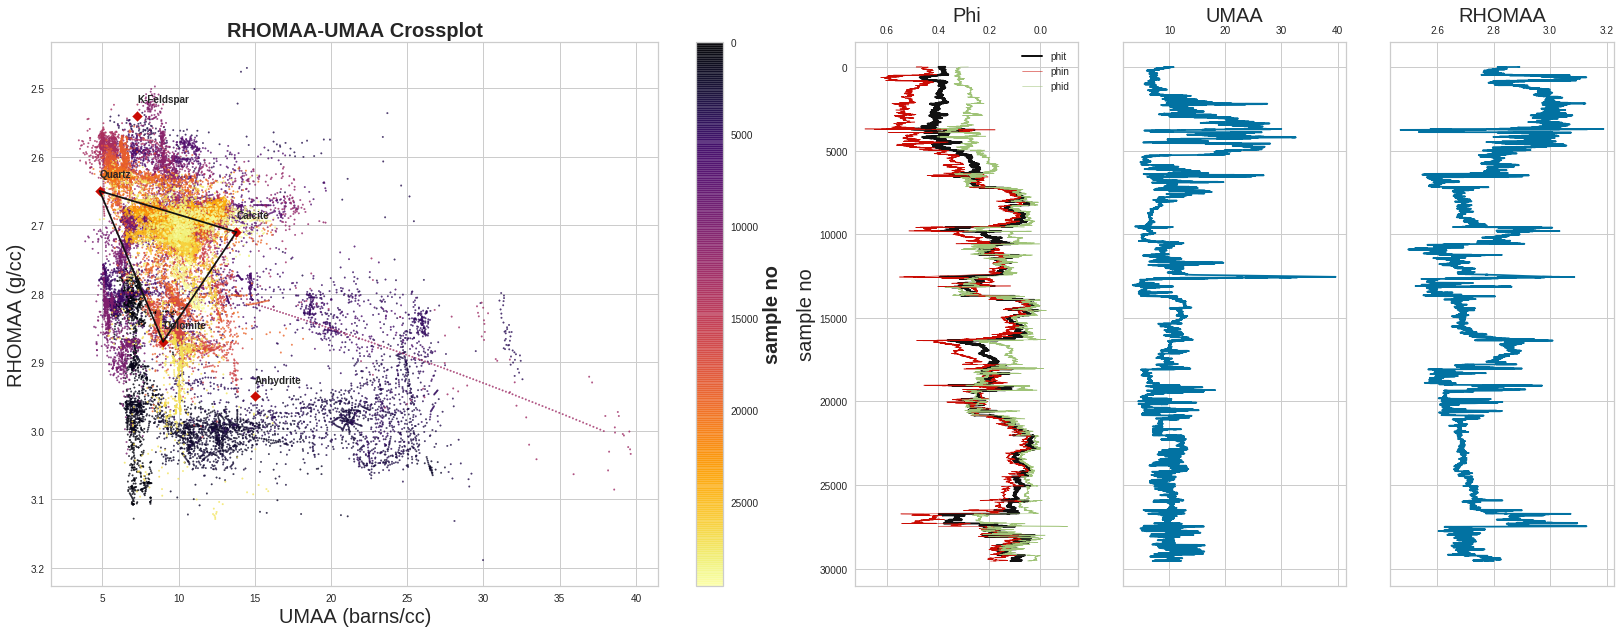

In [173]:
plot_rhomaa_umaa(df_subset['PE_est'], df_subset['ZDEN'], df_subset['CNC'])
plt.show()

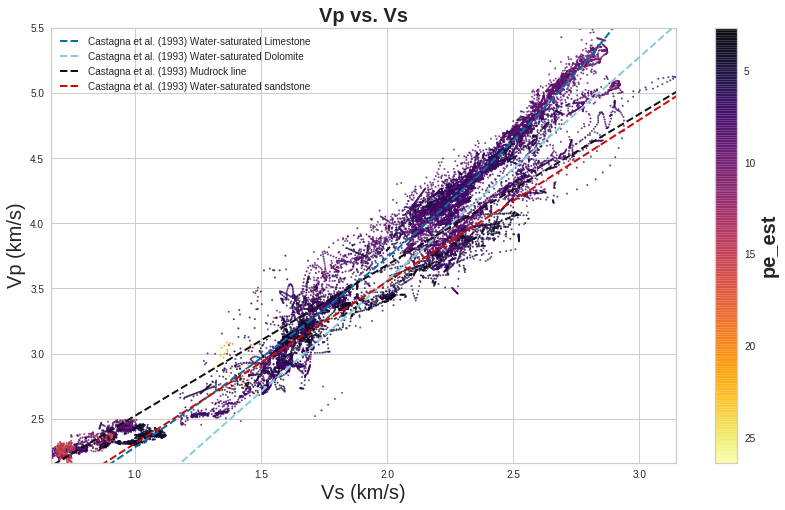

In [176]:
plot_vp_vs(x='DTC', y='DTS', color='PE_est', df=df_subset)
plt.show()

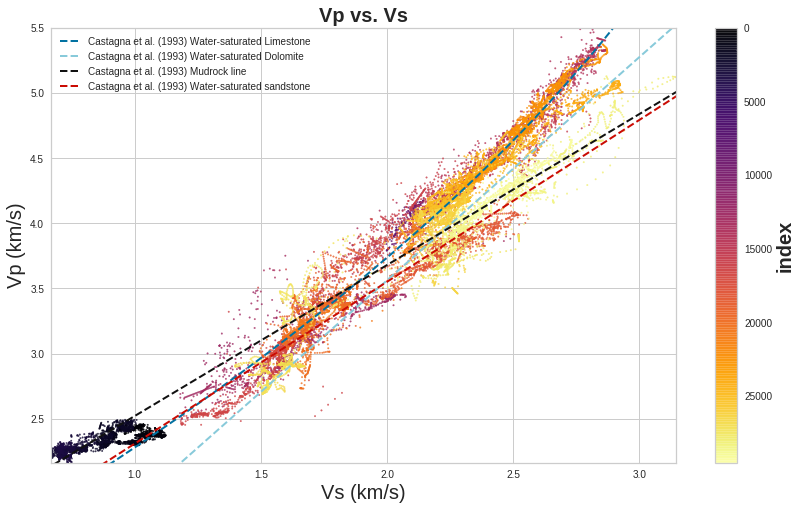

In [177]:
plot_vp_vs(x='DTC', y='DTS', color='index', df=df_subset)
plt.show()

**Create a new subset df replacing PE with PE_est and HRD with log_HRD**

In [182]:
df_subset_new = df_subset.copy()

In [183]:
df_subset_new.drop(['PE','HRD'], axis=1, inplace=True)

In [184]:
df_subset_new.head()

CNC         GR    ZDEN       DTC       DTS   log_HRD  PE_est
0  0.4633  60.081839  2.1849  126.5374  305.9166  0.625297  6.6753
1  0.4821  60.043330  2.1394  127.0895  309.3540  0.578129  6.6690
2  0.4821  60.004822  2.1370  127.4648  312.7448  0.533506  6.5535
3  0.4689  59.966313  2.1395  127.6743  315.0485  0.513003  6.6136
4  0.4865  59.927804  2.1377  127.7576  316.3320  0.497923  6.6984

In [185]:
df_subset_new.rename({'PE_est':'PE'}, axis=1, inplace=True)

In [186]:
df_subset_new.head()

CNC         GR    ZDEN       DTC       DTS   log_HRD      PE
0  0.4633  60.081839  2.1849  126.5374  305.9166  0.625297  6.6753
1  0.4821  60.043330  2.1394  127.0895  309.3540  0.578129  6.6690
2  0.4821  60.004822  2.1370  127.4648  312.7448  0.533506  6.5535
3  0.4689  59.966313  2.1395  127.6743  315.0485  0.513003  6.6136
4  0.4865  59.927804  2.1377  127.7576  316.3320  0.497923  6.6984

**Initially, we will build a model without imputing the missing values in DTC & DTS**

Drop NaN rows from DTC & DTS and reset the index

Later, we can attempt imputing the missing DTC & DTS values and fit a model using those curves.

In [187]:
df_subset_new.dropna(inplace=True)
df_subset_new.reset_index(drop=True, inplace=True)

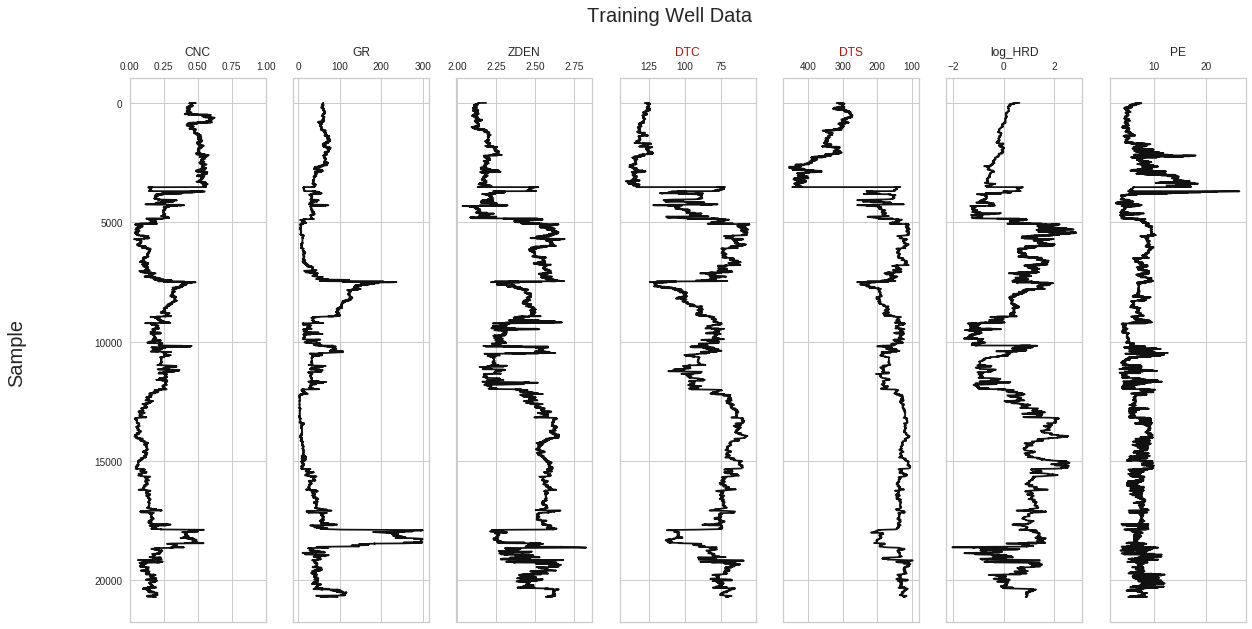

In [188]:
plot_well_curves(df_subset_new)
plt.show()

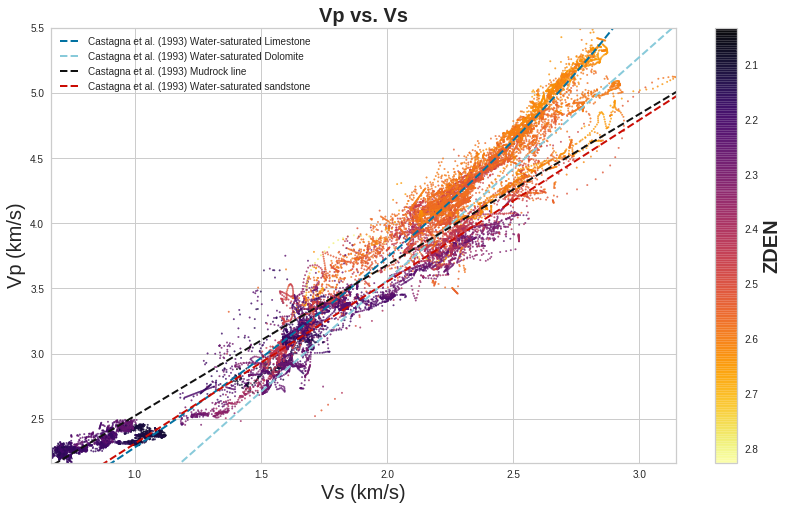

In [191]:
plot_vp_vs(x='DTC', y='DTS', color='ZDEN', df=df_subset_new)
plt.show()

## 6. <a name="model"></a>Model fitting to predict DTC & DTS

In this section, we will finally build our first model with the goal of predicting DTC & DTS using our other features.

As a reminder, the goal is to minimize RMSE.

The section will be broken down as follows:

1. [6A) Data Prep](#model-data-prep)

    1. Train-Test-Split
    
    1. Application of Standard Scaler
    
1. [6B) Feature Selection](#model-feature-sel)

1. [6C) Model Selection via cross_val_score](#model-model-sel)

1. [6D) Hyperparameter Tuning of best CV model using GridSearchCV](#model-hp-tune)

1. [6E) Evaluate Model Performance](#model-eval)

back to [top](#top)

### <a name="model-data-prep"></a>6A) Data Prep

back to [Model fitting](#model)

In [194]:
# Train-Test-Split
X = ['CNC', 'GR', 'ZDEN', 'PE', 'log_HRD']
y = ['DTC', 'DTS']

X_train, X_test, y_train, y_test = train_test_split(df_subset_new[X], df_subset_new[y], test_size=0.2, random_state=random_state)

In [195]:
print('X_train shape: {}\nX_test shape: {}\ny_train shape: {}\ny_test shape: {}'.format(
        X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train shape: (16557, 5)
X_test shape: (4140, 5)
y_train shape: (16557, 2)
y_test shape: (4140, 2)


In [196]:
scaler = StandardScaler()

In [197]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [198]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Shape of X_train_scaled: (16557, 5)


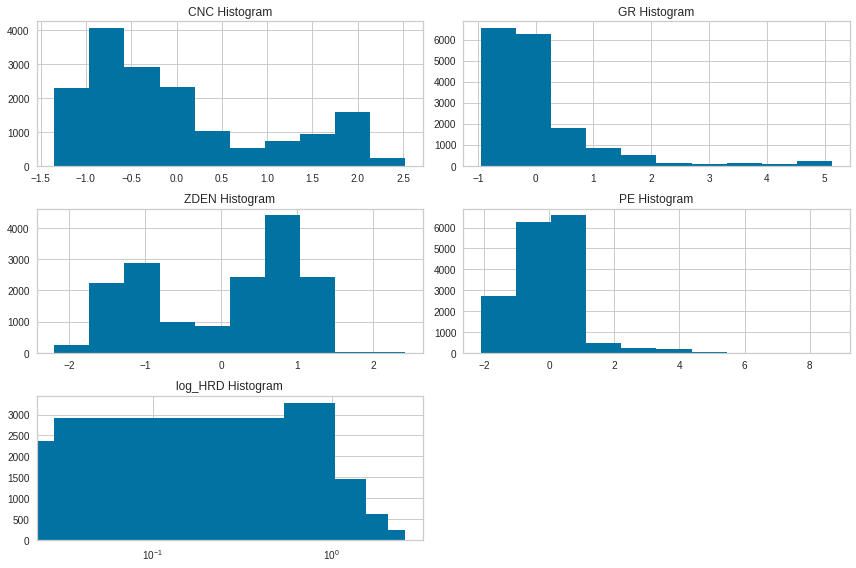

In [210]:
print('Shape of X_train_scaled: {}'.format(X_train_scaled.shape))
plot_data_distributions(pd.DataFrame(data=X_train_scaled, columns=df_subset_new[X].columns))
plt.show()

Shape of X_test_scaled: (4140, 5)


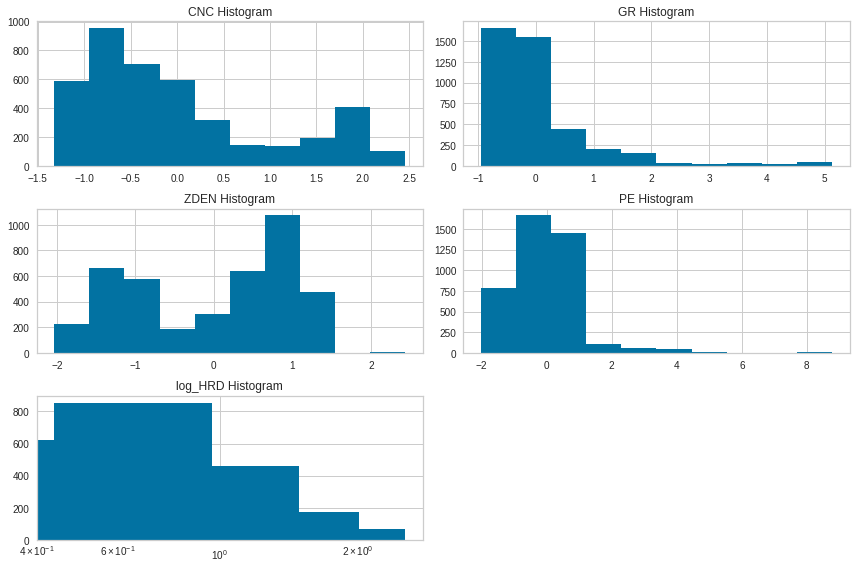

In [211]:
print('Shape of X_test_scaled: {}'.format(X_test_scaled.shape))
plot_data_distributions(pd.DataFrame(data=X_test_scaled, columns=df_subset_new[X].columns))
plt.show()

### <a name="model-feature-sel"></a>6B) Feature Selection

back to [Model Fitting](#model)

1. [PCA without first eliminating features](#model-pca-all-features)

1. [PCA after eliminating features](#model-pca-reduced-features)

Test for [multicollinearity](https://stackoverflow.com/a/25833792/12951266)

In [212]:
# calculate the correlation matrix
corr = np.corrcoef(X_train_scaled, rowvar=0)

In [213]:
# inspect the correlation coefficients
corr

array([[ 1.        ,  0.51723734, -0.80090364,  0.00661143, -0.50924169],
       [ 0.51723734,  1.        , -0.2505609 , -0.06928678,  0.01858992],
       [-0.80090364, -0.2505609 ,  1.        ,  0.25808228,  0.76426954],
       [ 0.00661143, -0.06928678,  0.25808228,  1.        ,  0.27860629],
       [-0.50924169,  0.01858992,  0.76426954,  0.27860629,  1.        ]])

In [214]:
# calculate the Eigenvalues, w, and Eigenvectors, v
w, v = np.linalg.eig(corr)

In [215]:
# Inspect the Eigenvalues for near-zero
w

array([2.58073493, 0.0953935 , 0.24367525, 1.17602253, 0.9041738 ])

None of the Eignevalues are very close to zero.  Calcuate [Variance Inflation Factor](https://etav.github.io/python/vif_factor_python.html), *VIF*, using statsmodels to be certain

In [217]:
# For each X, calculate VIF and save in a new dataframe
vif = pd.DataFrame()
X_train_scaled_wconst = np.hstack((X_train_scaled, np.ones(X_train_scaled[:,:1].shape))) # add in a constant
vif['VIF Factor'] = [variance_inflation_factor(X_train_scaled_wconst, i) for i in range(X_train_scaled_wconst.shape[1])]
feats = df_subset_new[X].columns.to_list()
feats.append('Constant')
vif['Features'] = feats

In [218]:
vif

VIF Factor  Features
0    4.957846       CNC
1    1.749288        GR
2    6.102440      ZDEN
3    1.348531        PE
4    2.772405   log_HRD
5    1.000000  Constant

VIF can also be calculated by taking the [Diagonal of the inverse of the Correlation Coefficient](https://stackoverflow.com/a/51463149/12951266)

In [219]:
vif_corr = np.linalg.inv(corr)

In [220]:
vif_corr.diagonal()

array([4.95784582, 1.74928804, 6.10244025, 1.34853115, 2.77240487])

All VIF Factors are below 10 so we should be safe from severe multicollinearity.  It is obvious that CNC & ZDEN dispaly collinearity, but we do not wish to drop them at this time.

Check the standardized features visually using a pairplot:

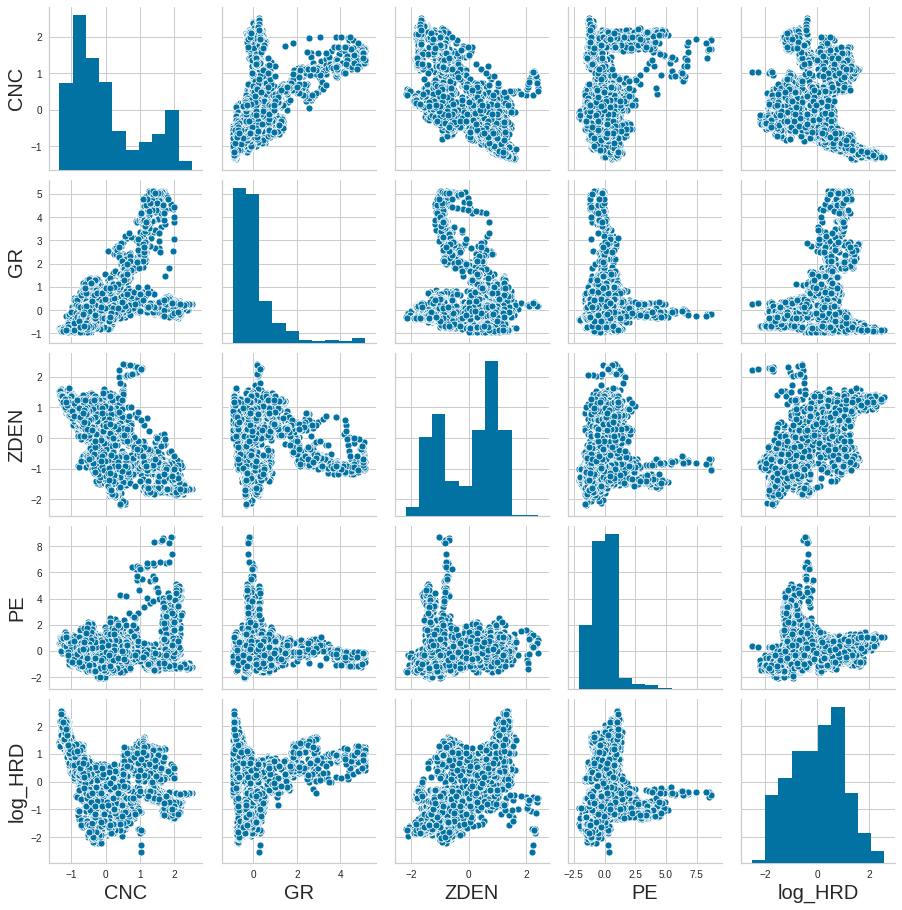

In [221]:
sns.pairplot(pd.DataFrame(data=X_train_scaled, columns=df_subset_new[X].columns))

Use Yellowbrick to visualize the features.

First, Rank1D which only compares one feature at a time using the Shapiro-Wilk algorithm by default.

In [227]:
viz = Rank1D(features=df_subset_new[X].columns.to_list())

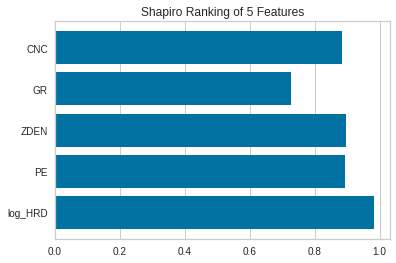

In [228]:
viz.fit(X_train_scaled, y_train)
viz.transform(X_train_scaled)
viz.show()

Next, use Rank2D to return the Pearson correlation score as a further check against collinearity

In [229]:
viz = Rank2D(features=df_subset_new[X].columns.to_list())

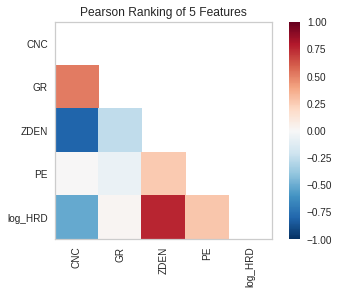

In [230]:
viz.fit(X_train_scaled, y_train)
viz.transform(X_train_scaled)
viz.show()

ZDEN and log_HRD display a highly positive collinear relationship, which CNC & ZDEN display a highly negative collinear relationship.

Let's try using <a name="model-pca-all-features"></a>PCA to reduce dimensionality before reducing the input features ...

In [231]:
pca = PCA(random_state=random_state)

In [232]:
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [233]:
X_train_pca = pca.transform(X_train_scaled)

In [235]:
print('Original shape: {}'.format(X_train_scaled.shape))
print('Transformed shape: {}'.format(X_train_pca.shape))

Original shape: (16557, 5)
Transformed shape: (16557, 5)


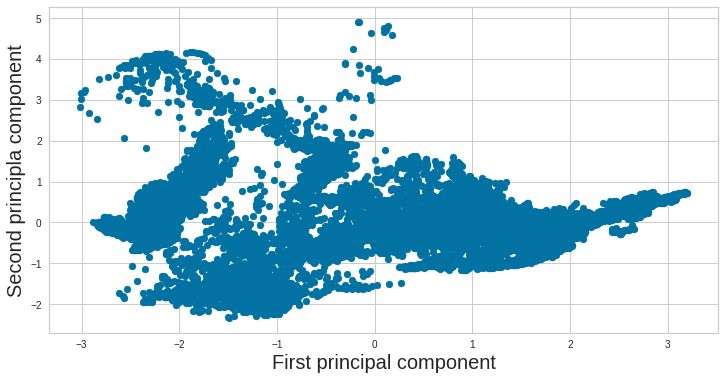

In [236]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(X_train_pca[:,0], X_train_pca[:,1])
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principla component')
plt.show()

Unfortunately, there is a lot of heteroscedasticity in the underlying dataset, so PCA may not be helpful here.

In [237]:
print('PCA component shape: {}'.format(pca.components_.shape))

PCA component shape: (5, 5)


In [238]:
print('PCA explained variance: {}'.format(pca.explained_variance_))

PCA explained variance: [2.58089081 1.17609356 0.90422841 0.24368996 0.09539926]


Do those values look familiar?  They are the same as the Eigenvalues we calculated above, but ordered by PCA component, or ordered by amount of variance explained in descending order.

In [239]:
print('PCA explained variance ratio: {}'.format(pca.explained_variance_ratio_))

PCA explained variance ratio: [0.51614699 0.23520451 0.18083476 0.04873505 0.0190787 ]


In [256]:
print('First two components explain {:.3f} of the variance in the data'.format(np.sum(pca.explained_variance_ratio_[:2])))
print('First three components explain {:.3f} of the variance in the data'.format(np.sum(pca.explained_variance_ratio_[:3])))

First two components explain 0.751 of the variance in the data
First three components explain 0.932 of the variance in the data


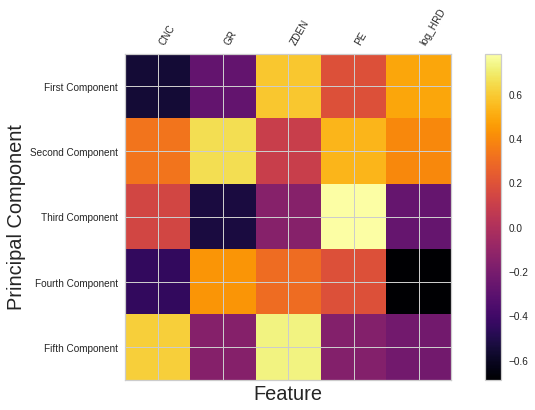

In [255]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
im = ax.matshow(pca.components_, cmap='inferno')
ax.set_yticks(range(0,5))
ax.set_yticklabels(['First Component', 'Second Component', 'Third Component', 'Fourth Component', 'Fifth Component'])
ax.set_xticks(range(0,5))
ax.set_xticklabels(df_subset_new[X].columns.to_list(), rotation=60, ha='left')
ax.set_xlabel('Feature')
ax.set_ylabel('Principal Component')
cbar = fig.colorbar(im, ax=ax)
plt.show()

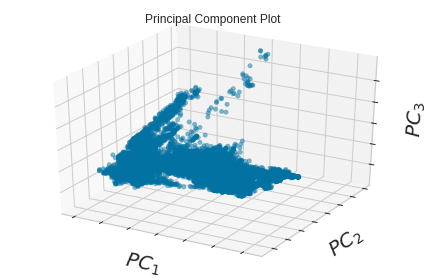

In [274]:
viz = PCA_yb(scale=False, projection=3, alpha=0.5)
viz.fit_transform(X_train_scaled)
viz.show()

Visualizing the first three principal components in a 3-dimensional scatter plot suggests that they may still be useful for building a model.

Let's try a quick cross_val_score with RandomForestRegressor using the first three (3) principal components to see whether or not this is a useful method

In [298]:
rfr_pca = RandomForestRegressor(random_state=random_state)

In [299]:
cvscore = cross_val_score(rfr_pca, X_train_pca[:,:3], y_train, cv=5)

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in score

In [300]:
cvscore.shape

(5,)

In [301]:
print('5-fold CV Score for RandomForestRegressor using first three principal components: {}'.format(cvscore))

5-fold CV Score for RandomForestRegressor using first three principal components: [0.98849556 0.99053451 0.98785017 0.98958301 0.98799741]


In [302]:
print('Mean 5-fold CV Score for RandomForestRegressor using first three principal components: {:.3f}'.format(cvscore.mean()))

Mean 5-fold CV Score for RandomForestRegressor using first three principal components: 0.989


Fit the RandomForestRegressor, without any hyperparameter tuning, using the first three principal components

In [326]:
rfr_pca.fit(X_train_pca[:,:3], y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [328]:
print('Train score using first three principal components: {:.3f}'.format(rfr_pca.score(X_train_pca[:,:3], y_train)))
X_test_pca = pca.transform(X_test_scaled)
print('Test score using first three principal components: {:.3f}'.format(rfr_pca.score(X_test_pca[:,:3], y_test)))

Train score using first three principal components: 0.999
Test score using first three principal components: 0.990


/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in score

**The cross-validated scores along with the train and test scores suggest that this might actually be a very powerful method in predicting DTC & DTS.**

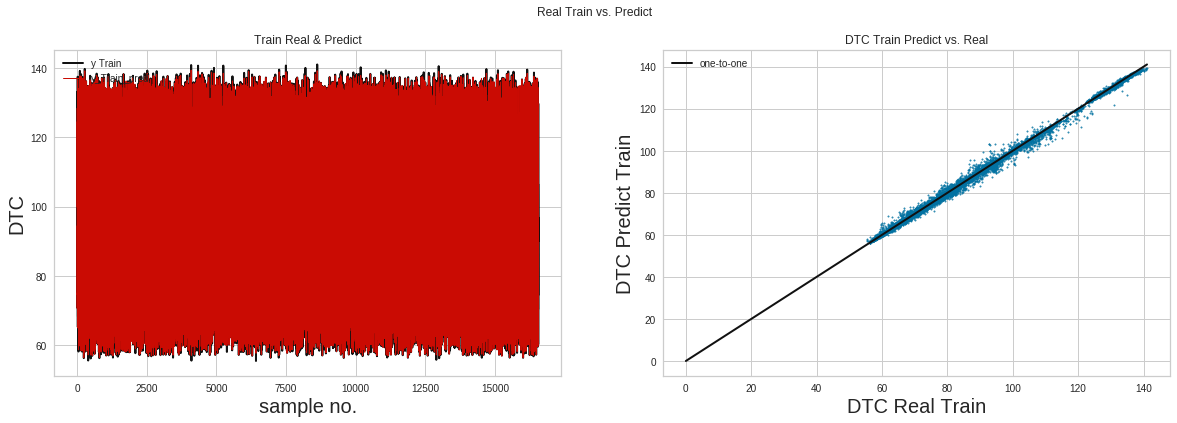

Train DTC RMSE: 0.944


In [329]:
plot_real_vs_pred(y_train['DTC'], rfr_pca.predict(X_train_pca[:,:3])[:,0], feat_name='DTC', split='Train')
plt.show()
print('Train DTC RMSE: {:.3f}'.format(evaluate_rmse(y_train['DTC'], rfr_pca.predict(X_train_pca[:,:3])[:,0])))

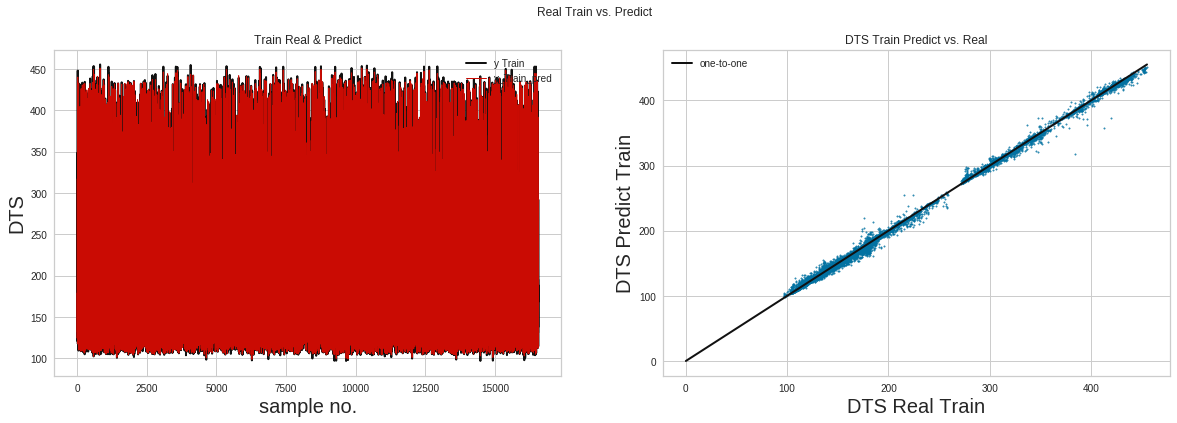

Train DTS RMSE: 3.158005556983008


In [330]:
plot_real_vs_pred(y_train['DTS'], rfr_pca.predict(X_train_pca[:,:3])[:,1], feat_name='DTS', split='Train')
plt.show()
print('Train DTS RMSE: {}'.format(evaluate_rmse(y_train['DTS'], rfr_pca.predict(X_train_pca[:,:3])[:,1])))

In [331]:
print('Overall Train RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, rfr_pca.predict(X_train_pca[:,:3])))))

Overall Train RMSE: 2.3305871145827277


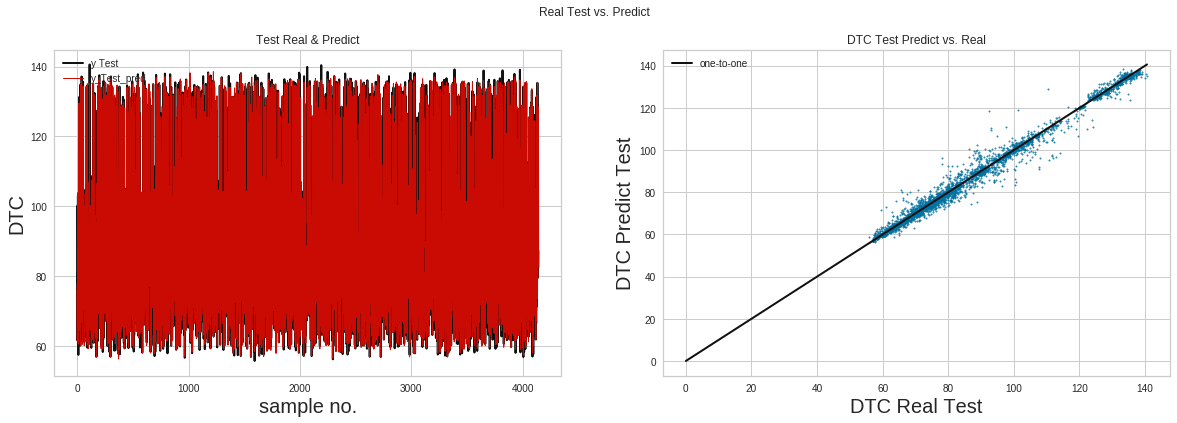

Test DTC RMSE: 2.5074232291246483


In [332]:
plot_real_vs_pred(y_test['DTC'], rfr_pca.predict(X_test_pca[:,:3])[:,0], feat_name='DTC', split='Test')
plt.show()
print('Test DTC RMSE: {}'.format(evaluate_rmse(y_test['DTC'], rfr_pca.predict(X_test_pca[:,:3])[:,0])))

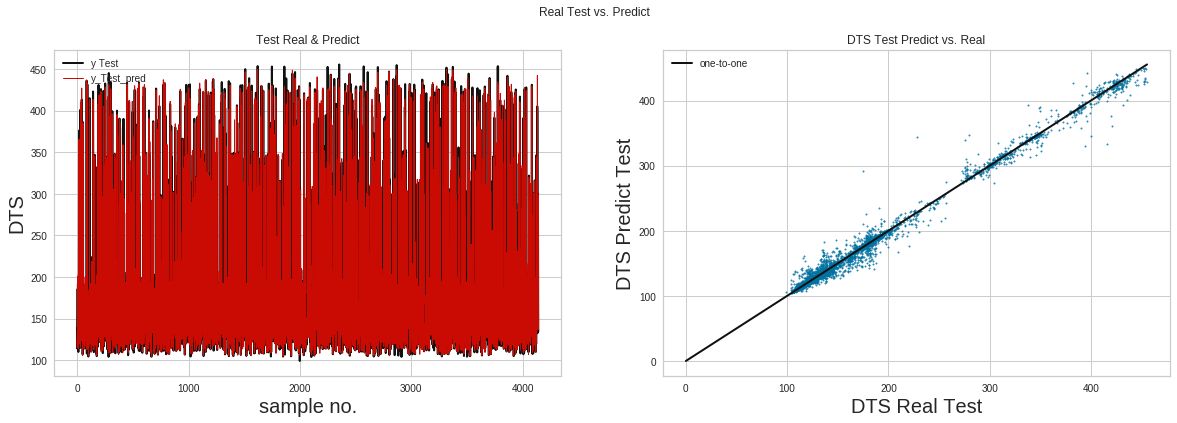

Test DTS RMSE: 8.460813130342059


In [333]:
plot_real_vs_pred(y_test['DTS'], rfr_pca.predict(X_test_pca[:,:3])[:,1], feat_name='DTS', split='Test')
plt.show()
print('Test DTS RMSE: {}'.format(evaluate_rmse(y_test['DTS'], rfr_pca.predict(X_test_pca[:,:3])[:,1])))

In [334]:
print('Overall Test RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, rfr_pca.predict(X_test_pca[:,:3])))))

Overall Test RMSE: 6.239893030995101


In [336]:
df_subset.columns

Index(['CNC', 'GR', 'HRD', 'PE', 'ZDEN', 'DTC', 'DTS', 'log_HRD', 'PE_est'], dtype='object')

In [340]:
df_subset_pca = df_subset.copy()
df_subset_pca.drop(['HRD','PE'], axis=1, inplace=True)
df_subset_pca.rename({'PE_est':'PE'}, axis=1, inplace=True)

In [341]:
df_subset_pca.head()

CNC         GR    ZDEN       DTC       DTS   log_HRD      PE
0  0.4633  60.081839  2.1849  126.5374  305.9166  0.625297  6.6753
1  0.4821  60.043330  2.1394  127.0895  309.3540  0.578129  6.6690
2  0.4821  60.004822  2.1370  127.4648  312.7448  0.533506  6.5535
3  0.4689  59.966313  2.1395  127.6743  315.0485  0.513003  6.6136
4  0.4865  59.927804  2.1377  127.7576  316.3320  0.497923  6.6984

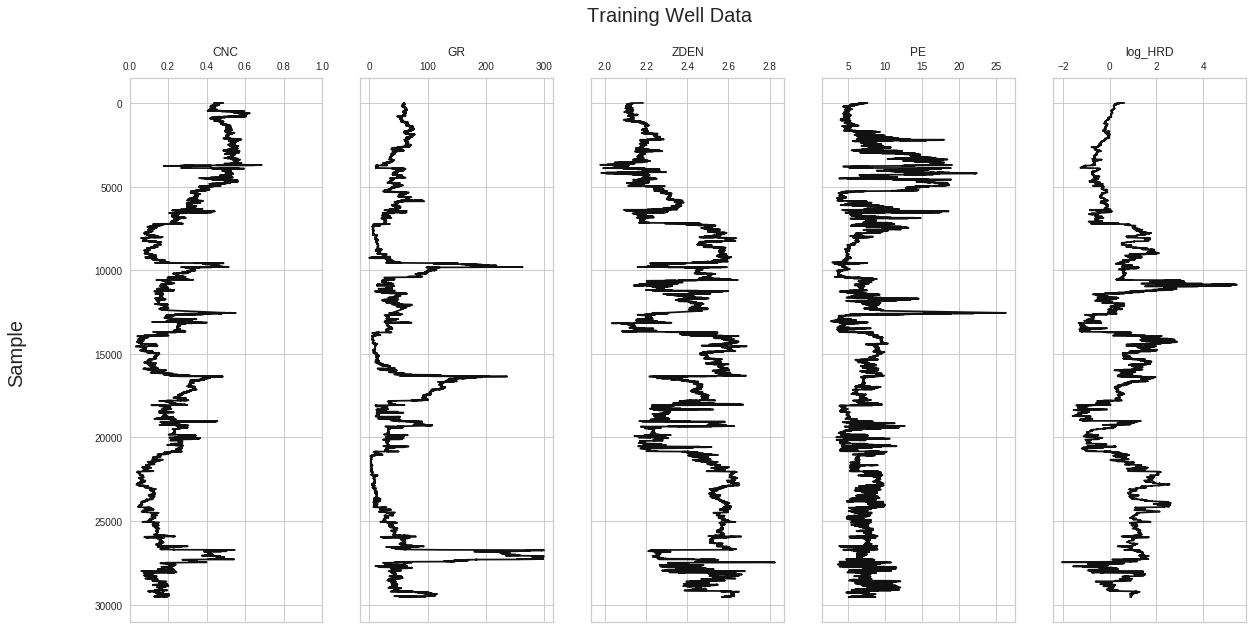

In [350]:
plot_well_curves(df_subset_pca[X])
plt.show()

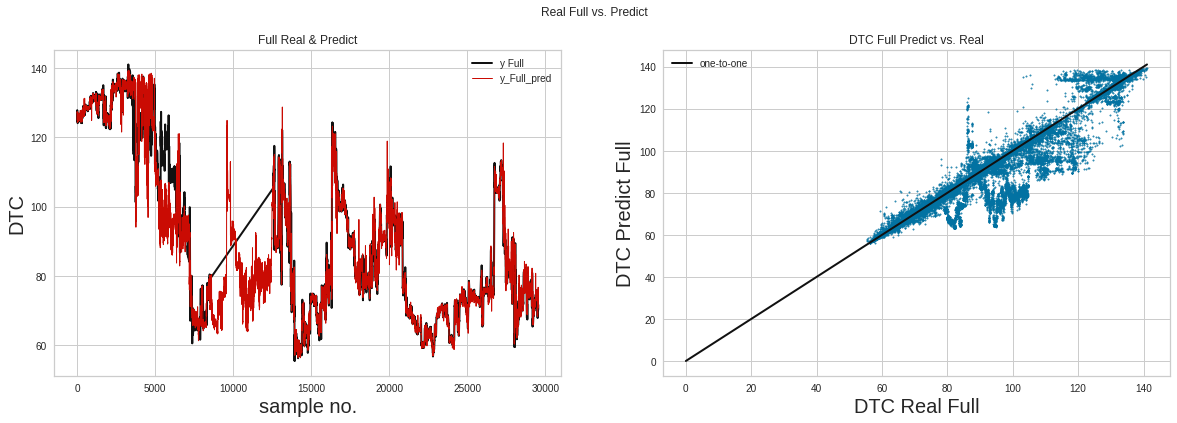

In [364]:
plot_real_vs_pred(df_subset_pca['DTC'].interpolate(limit_area='inside').dropna()[:-1], 
                 rfr_pca.predict(pca.transform(scaler.transform(df_subset_pca[X].dropna()))[:,:3])[:,0],
                 feat_name='DTC',
                 split='Full')
plt.show()

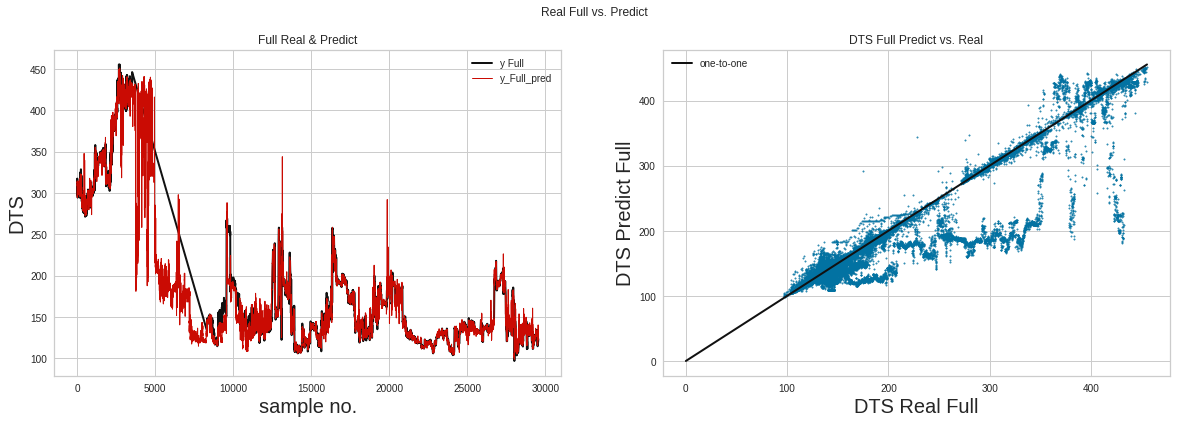

In [365]:
plot_real_vs_pred(df_subset_pca['DTS'].interpolate(limit_area='inside').dropna()[:-1], 
                 rfr_pca.predict(pca.transform(scaler.transform(df_subset_pca[X].dropna()))[:,:3])[:,1],
                 feat_name='DTS',
                 split='Full')
plt.show()

**Using PCA does seem to be providing a meaningful model in predicting DTC & DTS**

While there area some errors, overall, this is very promising.

<a name="model-pca-reduced-features"></a>Perhaps combining additional feature selection (RFE?), PCA, and hyperparameter tuning, we may be able to improve the results even further.

In [381]:
select_rfe_dtc = RFE(RandomForestRegressor(random_state=random_state), n_features_to_select=4)

In [390]:
select_rfe_dtc.fit(X_train_scaled, y_train['DTC'])

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=42, verbose=0,
                                    warm_start=False),
    n_features_to_select=4, step=1, verbose=0)

In [391]:
mask_rfe_dtc = select_rfe_dtc.get_support()
print('Selected Features : {}'.format(np.array(df_subset_new[X].columns.to_list())[mask_rfe_dtc]))

Selected Features : ['CNC' 'GR' 'ZDEN' 'log_HRD']


In [392]:
select_rfe_dts = RFE(RandomForestRegressor(random_state=random_state), n_features_to_select=4)

In [393]:
select_rfe_dts.fit(X_train_scaled, y_train['DTS'])

RFE(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                    criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    max_samples=None, min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    n_estimators=100, n_jobs=None,
                                    oob_score=False, random_state=42, verbose=0,
                                    warm_start=False),
    n_features_to_select=4, step=1, verbose=0)

In [394]:
mask_rfe_dts = select_rfe_dts.get_support()
print('Selected Features : {}'.format(np.array(df_subset_new[X].columns.to_list())[mask_rfe_dts]))

Selected Features : ['CNC' 'GR' 'ZDEN' 'log_HRD']


In [395]:
RandomForestRegressor(random_state=random_state).fit(X_train_scaled, y_train).feature_importances_

array([0.86866401, 0.03141339, 0.00882697, 0.00394716, 0.08714847])

/home/bendowdell/anaconda3/envs/pdda/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


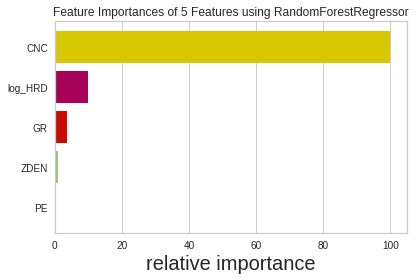

In [396]:
viz = FeatureImportances(RandomForestRegressor(random_state=random_state), labels=df_subset_new[X].columns.to_list())
viz.fit(X_train_scaled, y_train)
viz.show()

***Wow ...*** *this is almost a shocking result*

With default parameters, RandomForestRegressor is overwhelming returning CNC as the most important feature.  The next two, by a long shot, are log(HRD) and GR.

ZDEN provides very little importance.  However, this is not exactly surprising, as we have seen already that ZDEN exhibits moderately strong collinearity with ZDEN.

PE has almost zero contribution.  All that time predicting those bad values, while an interesting academic exercise, may have been time wasted.

CNC, log(HRD), & GR are also the three features that were kept in predicting PE.